# Loading modules/functions

In [1]:
#
# Jupyter python notebook to estimate ARGO Oxygen Correction.
# DOXY_ADJUSTED is corrected via the correction of the partial pressure PPOX as in 'Bittig and al (2018)'
# https://dx.doi.org/10.3389/fmars.2017.00429

#instruction to be able to zoom on matplotlib figure
%matplotlib widget 

# Path to LOCODOX python
import sys
sys.path.insert(0,'/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/source')

# Import python module
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
from datetime import date
import copy
import pwlf


# Import module developped for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, copy_attr, write_ASCII_file
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_Gain_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa, plot_Theta_S, plot_CTD_Argo_Pos, plot_cmp_corr_NCEP_with_error, plot_cmp_corr_WOA_with_error, plot_ref_div_argo
from m_read_write_netcdf import corr_file

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_99199/1897529185.py:24: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


# User initialization

In [2]:
#####################
# Initialization.
###################

# Results Directory.
# The BD files and the ASCII result file ill be created in this directory.
###################################################
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
# ASCII file root containing the different corrections estimated
racine_res = 'locodox_res_'

# Relative error to be written in the BD files
percent_relative_error = 2.0


# Which plot ?
###############
# info_plot = 1 : all plots
# info_plot = 0 : not all plots are created.
info_plot = 1 
# Figures Directory
rep_fic_fig = '/Users/chemon/tmp' #'/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/figures'

# ARGO Directory : contains 1 subdirectory by float.
# In the Argo float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
# WMO Float (string format) to be corrected / Cycles to be used
#################################################################
# Argo directory
#rep_data_argo = '/Volumes/argo/gdac/dac/coriolis/'
rep_data_argo = '/Volumes/argo/gdac/dac/coriolis/'
# Argo float
#num_float = '6902882' 
num_float = '6902807'
# Cycle to use to estimate the correction
first_cycle_to_use = 1
last_cycle_to_use = 400

#
# sensor_aanderaa = 1 if aanderaa sensor, 0 if rinko sensor
sensor_aanderaa = 1
if sensor_aanderaa == 1:
    racine_res = racine_res + '_aanderaa_' 
    pcoef2 = 0.00022
    pcoef3 = 0.0419
else:
    racine_res = racine_res + '_rinko_' 
    pcoef2 = 0
    pcoef3 = 0.04

    
# Complete ASCII file name
fic_res_ASCII = os.path.join(rep_fic_res,racine_res + num_float)


# Which ARGO variables (PRES/PSAL/TEMP) to be used to estimate correction.
#################################################
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2
# Which QC used for pressure, temperature, salinity and oxygen.
# In Sprof, we got interpolated data (flag=8)
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]
# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

# CTD comparison to estimate a supplement gain.
##################################################
# cmp_ctd = 1 : we used CTD, 0 otherwise
cmp_ctd = 1
# rep_ctd : CTD directory
#rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/']
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
#fic_ctd = ['ovid18_PRES.nc'] 
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
#num_cycle = np.array([3]) 
# num_ctd : CTD to be compared with cycle. 
# num_cycle[I] is compared with num_ctd[I].
#num_ctd = np.array([105]) 


rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/RREX/RREX17/']
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
fic_ctd = ['rr17_PRES.nc'] 
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
num_cycle = np.array([1]) #np.array([5]) 
# num_ctd : CTD to be compared with cycle. 
# num_cycle[I] is compared with num_ctd[I].
num_ctd = np.array([26])  #np.array([7]) 

# Pressure effect 
###################
# Pressure for pressure effect estimation. We use pressure > pressure_threshold
pressure_threshold = 1000  

# Bathymetry plot
# Bathymetry file
fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
#  Dataset associated
ds_bathy = xr.open_dataset(fic_bathy)
# extension for Position plot
extend_lon_lat = 0.5
# Depth for bathymetry contouring
depths = np.arange(-7000,500,500)

# WOA correction
##################
# fic_woa : WOA file
# Tis file contains the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# This file is created by an internal LOPS routine. It can change.
#
# WOA file
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'
# Min and max pressure used to estimate WOA correction. 
min_pres_interp = 0
max_pres_interp = 25

# NCEP Correction
######################
# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO reading and selection
## We use the NetCDF Argo file 
- meta file
- Sprof file
- Rtraj file

In [3]:
# Read ARGO files 
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/argo/gdac/dac/coriolis/6902807/6902807_meta.nc
/Volumes/argo/gdac/dac/coriolis/6902807/6902807_Sprof.nc
/Volumes/argo/gdac/dac/coriolis/6902807/6902807_Rtraj.nc


In [4]:
# Launch data
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)
# Delta time from launch date
delta_T_Sprof = diff_time_in_days(ds_argo_Sprof['JULD'],launch_date)

2017-07-24T20:50:00.000000000
-0.291


In [5]:
# Select the cycles to be used
ds_argo_Sprof = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Sprof['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Rtraj = ds_argo_Rtraj.where( (ds_argo_Rtraj['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Rtraj['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Sprof['PLATFORM_NUMBER'] = ds_argo_Sprof['PLATFORM_NUMBER'].astype(int) # The where transform the nan from int to float ...

In [6]:
# Check ds_argo_Sprof
ds_argo_Sprof

<xarray.Dataset> Size: 68MB
Dimensions:                       (N_PROF: 272, N_PARAM: 4, N_CALIB: 2,
                                   N_LEVELS: 2012)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     (N_PROF) object 2kB 'Argo synthetic profile...
    FORMAT_VERSION                (N_PROF) object 2kB '1.0 ' '1.0 ' ... '1.0 '
    HANDBOOK_VERSION              (N_PROF) object 2kB '1.2 ' '1.2 ' ... '1.2 '
    REFERENCE_DATE_TIME           (N_PROF) datetime64[ns] 2kB 1950-01-01 ... ...
    DATE_CREATION                 (N_PROF) datetime64[ns] 2kB 2024-12-05T12:1...
    DATE_UPDATE                   (N_PROF) datetime64[ns] 2kB 2024-12-05T12:1...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 2MB 271.0 ... nan
    DOXY_QC                       (N_PROF, N_LEVELS) float64 4MB 4.0 0.0 ... 0.0
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 2MB 0.0 nan ... nan
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 2MB nan nan ... nan
    DOXY_ADJUSTED_QC              (N_PROF, N_LEVELS) float64 4MB 4.0 0.0 ... 0.0
    DOXY_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 2MB nan nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-05T12:15:43Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

# Plots

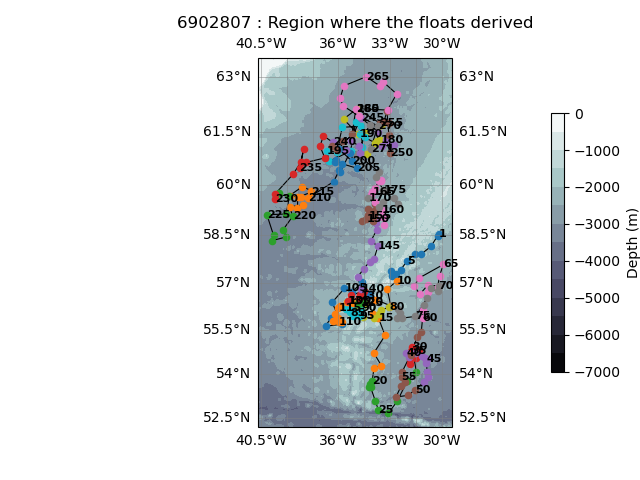

In [7]:
# Maps plotting
if info_plot==1:
    ds_bathy = xr.open_dataset(fic_bathy)
    extend_lon_lat = 0.5
    depths = np.arange(-7000,500,500)
    plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_pos.png'))

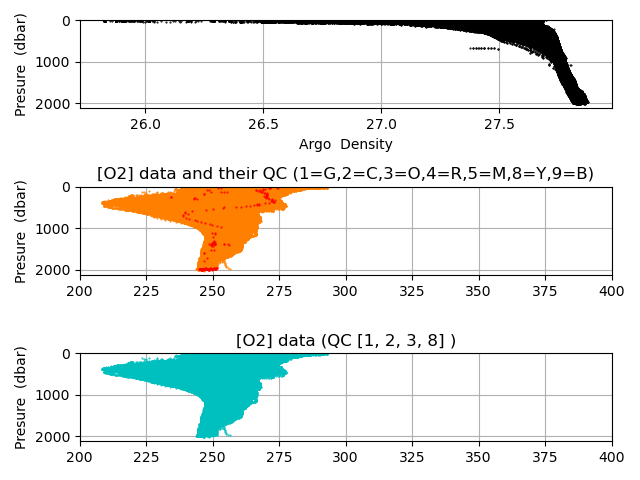

In [8]:
# DOXY_QC plot with PRES/PSAL/TEMP
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc.png'))

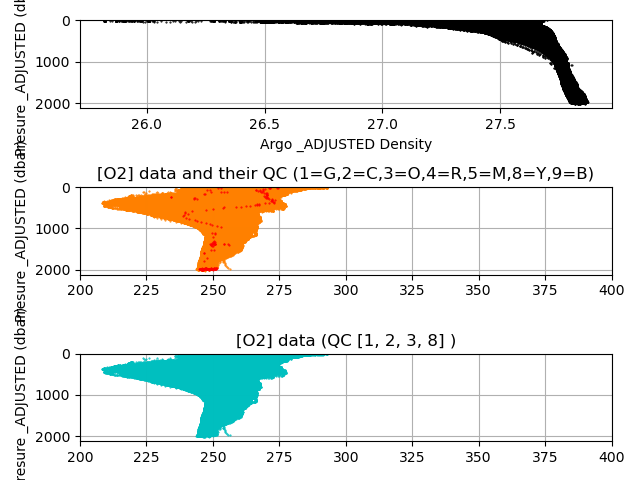

In [9]:
# Same with DATA ADJUSTED (PRES,PSAL,TEMP)
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc_PTS_adjusted.png'))

PRES
TEMP
PSAL


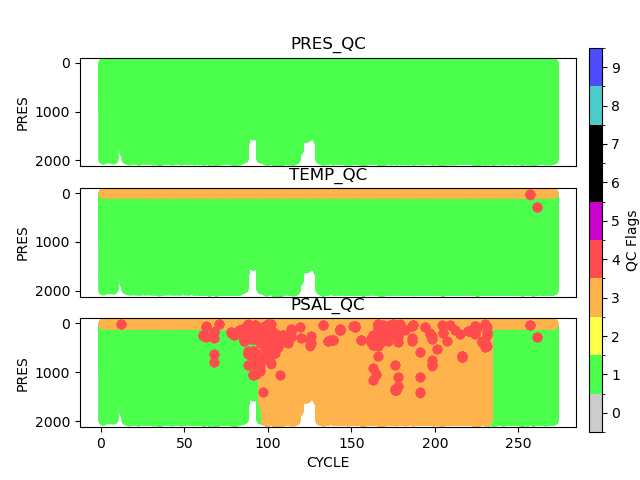

In [10]:
# PRES/PSAL/TEMP QC
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_QC.png'))

PRES_ADJUSTED
TEMP_ADJUSTED
PSAL_ADJUSTED


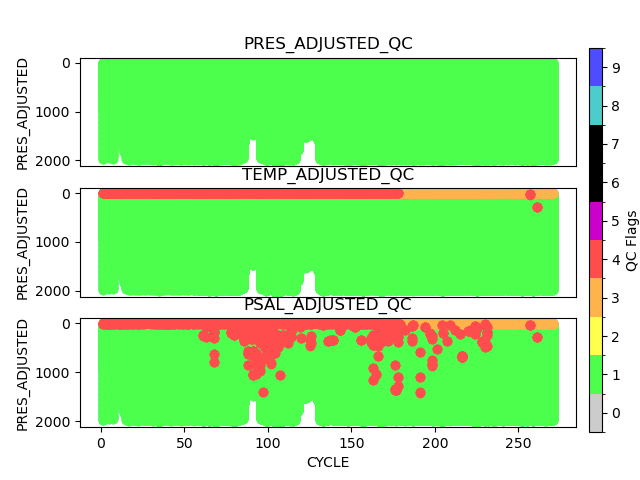

In [11]:
# Same with adjusted DATA
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_Adjusted_QC.png'))

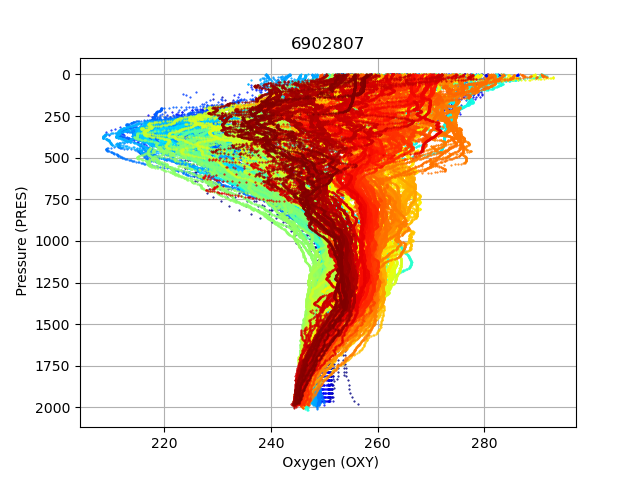

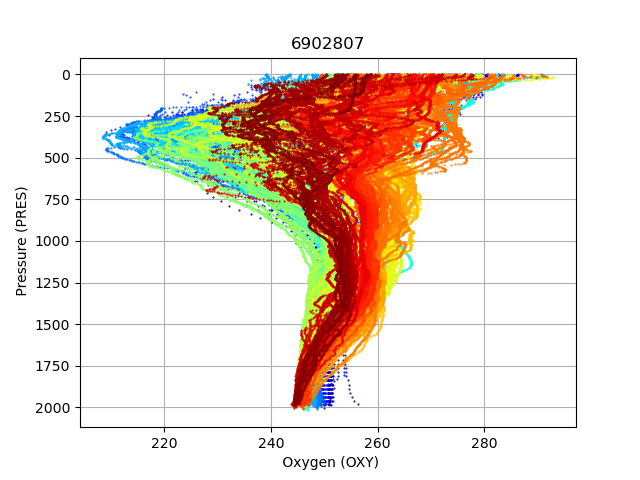

In [12]:
# DOXY RAW DATA
_=plot_DOXY_cycle(ds_argo_Sprof,qc_keep=[1,2,3,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_cycle.png'))
_=plot_DOXY_cycle(ds_argo_Sprof) # qc_keep = [1,2,3,4,8] by default


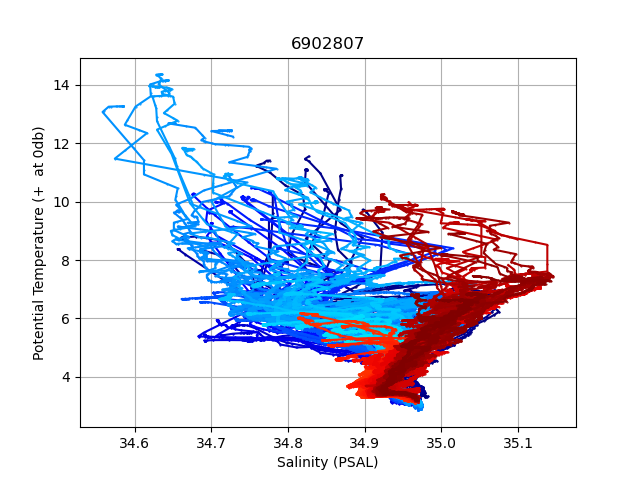

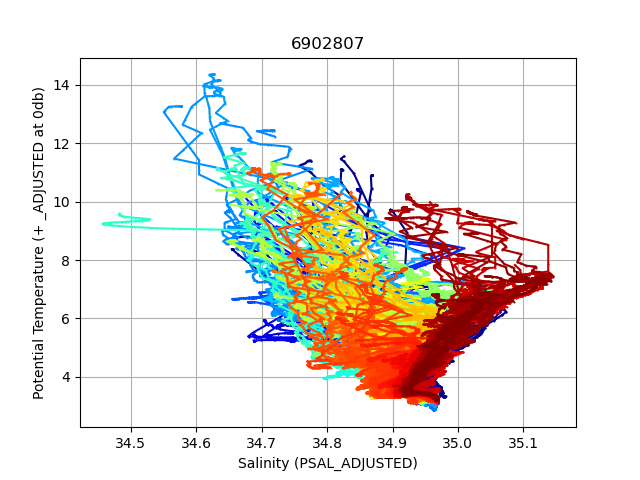

In [13]:
# Theta/S
#_=plot_Theta_S(ds_argo_Sprof)
#_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED')
_=plot_Theta_S(ds_argo_Sprof,qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S.png'))
_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED',qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S_adjusted.png'))



# Get WOA and NCEP DATA
- Attention : The WOA file is a LOPS home-made file

In [14]:
# WOA file reading
ds_woa = open_WOA_file(fic_WOA)
download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

We force Longitude in [-180 180]
File slp.2017.nc already exists with the same size. No Download
File air.sig995.2017.nc already exists with the same size. No Download
File rhum.sig995.2017.nc already exists with the same size. No Download
File slp.2018.nc already exists with the same size. No Download
File air.sig995.2018.nc already exists with the same size. No Download
File rhum.sig995.2018.nc already exists with the same size. No Download
File slp.2019.nc already exists with the same size. No Download
File air.sig995.2019.nc already exists with the same size. No Download
File rhum.sig995.2019.nc already exists with the same size. No Download
File slp.2020.nc already exists with the same size. No Download
File air.sig995.2020.nc already exists with the same size. No Download
File rhum.sig995.2020.nc already exists with the same size. No Download
File slp.2021.nc already exists with the same size. No Download
File air.sig995.2021.nc already exists with the same size. No Download
File

# Prepare data for WOA Correction

In [15]:
################################## 
# Correction estimated with WOA
##################################
# ARGO data needed for WOA correction.
# ds_argo contains variables needed to estimate correction with WOA.
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)
ds_argo

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


<xarray.Dataset> Size: 26MB
Dimensions:       (N_PROF: 272, N_LEVELS: 2012)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    TEMP_ARGO     (N_PROF, N_LEVELS) float32 2MB 10.01 10.01 10.0 ... nan nan
    TEMP_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 8.0 1.0 8.0 1.0 ... 0.0 0.0 0.0
    PSAL_ARGO     (N_PROF, N_LEVELS) float32 2MB 34.87 34.87 34.88 ... nan nan
    PSAL_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 8.0 1.0 8.0 1.0 ... 0.0 0.0 0.0
    DOXY_ARGO     (N_PROF, N_LEVELS) float32 2MB nan nan nan nan ... nan nan nan
    DOXY_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 4.0 0.0 4.0 0.0 ... 0.0 0.0 0.0
    PRES_ARGO     (N_PROF, N_LEVELS) float32 2MB 9.009 9.3 13.91 ... nan nan nan
    PRES_ARGO_QC  (N_PROF, N_LEVELS) float64 4MB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    JULD          (N_PROF) datetime64[ns] 2kB 2017-07-24T23:42:00 ... 2024-12...
    LONGITUDE     (N_PROF) float64 2kB -30.19 -30.24 -30.63 ... -33.72 -34.13
    LATITUDE      (N_PROF) float64 2kB 58.55 58.48 58.15 ... 61.93 61.67 61.02
    CYCLE_NUMBER  (N_PROF) float64 2kB 1.0 1.0 2.0 3.0 ... 269.0 270.0 271.0
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-12-05T12:15:43Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

In [16]:
# Delta Times from launch_date
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [17]:
# Interp WOA data on ARGO time
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset> Size: 4GB
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 112B -15.25 15.0 46.0 75.0 ... 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    density   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
101.86589

In [18]:
# Interpolation WOA et ARGO on regular grid (defined at the beginning)
print(f"WOA/ARGO Interpolation between {min_pres_interp} et {max_pres_interp}")
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

WOA/ARGO Interpolation between 0 et 25
Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [19]:
# Add attributes in data interp 
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [20]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

In [21]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

# Prepare data for NCEP Correction
## We recover the InAir data and InWater Argo Data from the Rtraj file.
- In the Rtraj file, the pump is off. So, we decide to take the salinity from the Sprof file, near the surface (between min_pres and max_pres defined by the user)
- In the RTraj file, all TEMP_QC is 3. But we decide to take it into account because the temperature is important to calculate the watervapor. <br>
  The temperature in the Rtraj is closer to the InAir and InWater data. So, we use it. We compare it to the Temperature from the Sprof and a message is written if the difference is >0.5.
- NCEP PPOX is calculated from the article 'Tackling Oxygen Optode Drift : Near Surface and In-Air Oxygen optode Measurements on a float provide an accurate in situ Reference' <br>
 (Bittg and al. 2015) : <br>
     - PPOX_air = 0.20946 * (P_air - P_vap) where P_air = Atmospheric pressure, P_vap : water vapor scaled to the optode height
     - P_vap = P_vap_S + (Rhum_10m * P_vap_10m - P_vap_S) * ln(optode_height / 1e-4)/ln(10/1e-4) avec <br>
         - P_vap_S : salinity/temperature saturation water vapor at seasurface
         - P_vap_1Om : salinity/temperature saturation water vapor at 10m
         - Rhum_10m : relative humidity at 10m

We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


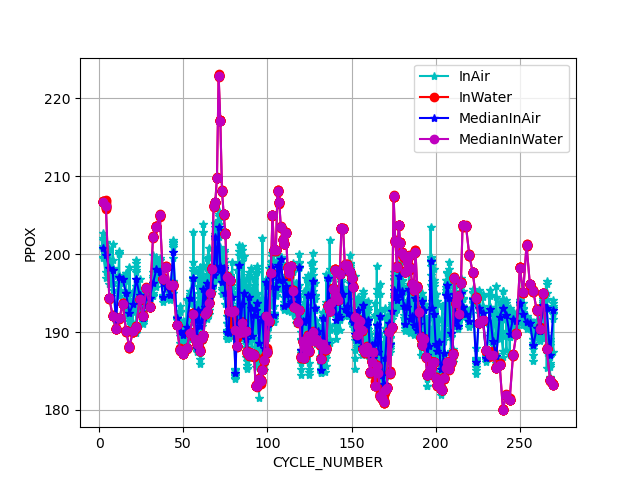

PSAL_ADJUSTED Data is used
Cycle 149.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature
Cycle 178.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature
Cycle 264.0
Rtraj Temperature  differs more than  0.5 degrees from Sprof Temperature


In [22]:
# Get ARGO PPOX inair/inwater for NCEP correction
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
plt.savefig(os.path.join(rep_fic_fig,num_float +'_InAir_InWater.png'))


In [23]:
# Compute NCEP data at ARGO time
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [24]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)

# Plot REF/ARGO
The correction used is :
- Ref = (G * (1 + D/100 * deltaT / 365)) * (data + Offset) <br>
 Attention : Offset is supposed to be 0 (and so is not estimated) <br>
G is the gain <br>
D is the time drift <br>
deltaT is the time, in days, from the launch date
- So, Ref/data is : (G * (1 + D/100 * deltaT / 365)) = A * deltaT + B <br>
  The correction is a straight line as a function of deltaT.

  The plot shows this correction. It can help the user to choose if he has to choose a piece wise correction or not.
## Ref_WOA/ppox_Argo


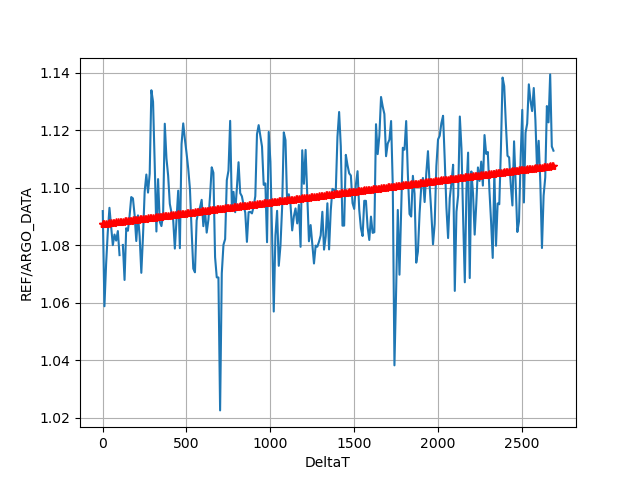

In [25]:
plot_ref_div_argo(delta_T_WOA,ppox_WOA_mean,ppox_ARGO_mean)

## Ref_NCEP/ppox_ARGO

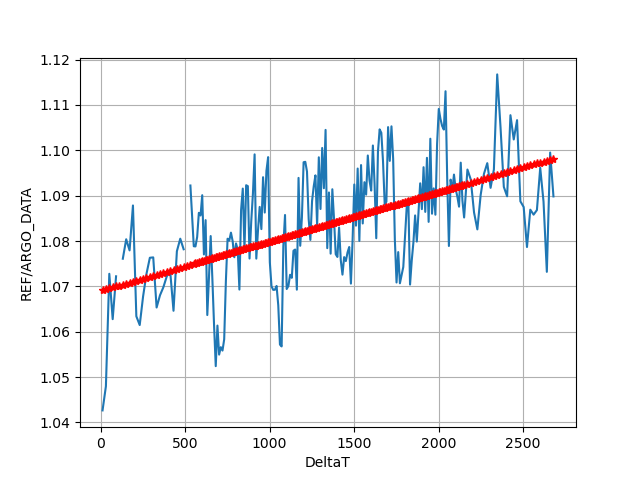

In [26]:
plot_ref_div_argo(delta_T_NCEP,NCEP_PPOX,PPOX1)

# Correction estimation (without piece, just 1 segment)
We calculate the correction on the the oxygen partial pressure (PPOX)
## WOA Correction
- 2 possible corrections :
    - a gain : Ref/data = G 
    - a gain and a time drift : Ref/data = (G + (1 * D * deltaT/365)) <br>
We use curve_fit for G (gain) and D (time drift) estimation

In [27]:
# Correction WOA : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')
perr_Gain_WOA = np.sqrt(np.diag(covariance))
print(f"WOA Gain estimated : {params_Gain_WOA} with an error {perr_Gain_WOA}")


WOA Gain estimated : [1.09746638] with an error [0.00105648]


In [28]:
# Correction WOA : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_Derive_WOA = np.sqrt(np.diag(covariance))
print(f"WOA Gain/Drift estimated : {params_Gain_Derive_WOA} with an error {perr_Gain_Derive_WOA}")


WOA Gain/Drift estimated : [1.08726857 0.25269017] with an error [0.00199966 0.04336758]


## NCEP Correction
- 4 possible corrections:
    - a gain (G)
    - a gain (G) estimated with CarryOver (C)
    - a gain (G) and a time drift (D)
    - a gain (G) and a time drift (D) estimated with CarryOver (C) <br>
We use curve_fit for G, D and C estimation. <br>
The Carryover represents the fact that the InAir Argo PPOX may be polluted by water (waves) <br>
The CarryOver is determinated by the article 'Oxygen Optode Sensors : Principle, characterization, calibration and application in the Ocean' <br>
(Bittig and al. 2018) : <br>
        - G * PPOX_obs_sufr - PPOX_air = C * (G * PPOX_obs_water - PPOX_air)

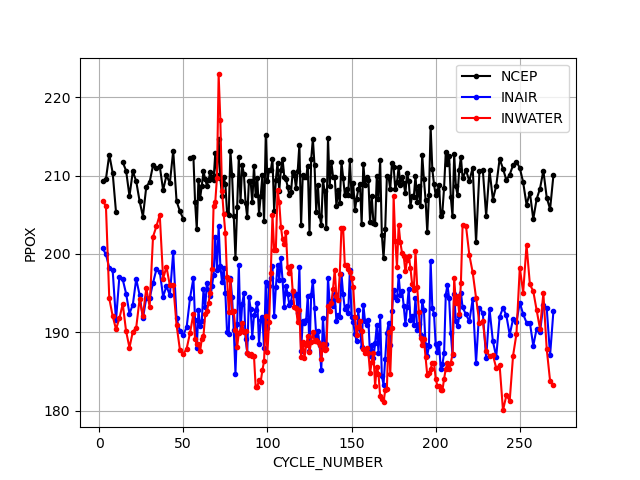

In [29]:
# Plot NCEP and ARGO PPOX
_ = plot_ppox_Inair_Inwater_Ncep(dsair,dsinwater,NCEP_PPOX)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_NCEP_InAir_InWater.png'))

In [30]:
# Estimate Gain correction with NCEP 
# without CarryOver
initial_guess = 1
# Gain
params_Gain_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_NCEP = np.sqrt(np.diag(covariance))
print(f"NCEP Gain estimated : {params_Gain_NCEP} with an error {perr_Gain_NCEP}")

# with CarryOver
initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
perr_Gain_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(f"NCEP Gain/CarryOver estimated : {params_Gain_NCEP_CarryOver} with an error {perr_Gain_NCEP_CarryOver}")


NCEP Gain estimated : [1.08379476] with an error [0.00087724]
NCEP Gain/CarryOver estimated : [1.0834747 0.1628476] with an error [0.00078224 0.01775613]


In [31]:
# Estimate Gain/Drift correction with NCEP 
# without CarryOver
initial_guess = [1, 0]  # G/C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_Derive_NCEP = np.sqrt(np.diag(covariance))
print(f"Gain/Drift estimated : {params_Gain_Derive_NCEP} with an error {perr_Gain_Derive_NCEP}")

# with CarryOver
initial_guess = [1, 0, 0]  # G/C/D
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
perr_Gain_Derive_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(f"Gain/CarryOver/Drift estimated : {params_Gain_Derive_NCEP_CarryOver} with an error {perr_Gain_Derive_NCEP_CarryOver}")


Gain/Drift estimated : [1.06898082 0.37180505] with an error [0.00162453 0.03705413]
Gain/CarryOver/Drift estimated : [1.0693433  0.15265708 0.35713129] with an error [0.00137861 0.01432682 0.03159252]


In [32]:
# We don't need the CarryOver value.
params_Gain_NCEP_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
params_Gain_Derive_NCEP_CarryOver = np.array(params_Gain_Derive_NCEP_CarryOver[[0,2]])

In [33]:
print(f"Gain Estimation with WOA : {params_Gain_WOA[0]:.4f} with an error {perr_Gain_WOA[0]:.4f}")
print(f"Gain/Drift Estimation with WOA : {params_Gain_Derive_WOA[0]:.4f} / {params_Gain_Derive_WOA[1]:.4f} with an error {perr_Gain_Derive_WOA[0]:.4f} / {perr_Gain_Derive_WOA[1]:.4f}")
print(f"Gain Estimation with NCEP : {params_Gain_NCEP[0]:.4f} with an error {perr_Gain_NCEP[0]:.4f}")
print(f"Gain Estimation with NCEP with CarryOver : {params_Gain_NCEP_CarryOver[0]:.4f} with an error {perr_Gain_NCEP_CarryOver[0]:.4f}")
print(f"Gain/Drift Estimation with NCEP : {params_Gain_Derive_NCEP[0]:.4f} / {params_Gain_Derive_NCEP[1]:.4f} with an error {perr_Gain_Derive_NCEP[0]:.4f} / {perr_Gain_Derive_NCEP[1]:.4f}")
print(f"Gain/Drift Estimation with NCEP with CarryOver : {params_Gain_Derive_NCEP_CarryOver[0]:.4f} / {params_Gain_Derive_NCEP_CarryOver[1]:.4f} with an error {perr_Gain_Derive_NCEP_CarryOver[0]:.4f} / {perr_Gain_Derive_NCEP_CarryOver[2]:.4f}")

Gain Estimation with WOA : 1.0975 with an error 0.0011
Gain/Drift Estimation with WOA : 1.0873 / 0.2527 with an error 0.0020 / 0.0434
Gain Estimation with NCEP : 1.0838 with an error 0.0009
Gain Estimation with NCEP with CarryOver : 1.0835 with an error 0.0008
Gain/Drift Estimation with NCEP : 1.0690 / 0.3718 with an error 0.0016 / 0.0371
Gain/Drift Estimation with NCEP with CarryOver : 1.0693 / 0.3571 with an error 0.0014 / 0.0316


GAIN WOA
Number of pieces : 1
[1.09746638]
Gain NCEP
Number of pieces : 1
[1.08379476]
Gain/Derive WOA
Number of pieces : 1
[1.08726857 0.25269017]
Gain/Derive Ncep
Number of pieces : 1
[1.06898082 0.37180505]
Gain Ncep CarryOver
Number of pieces : 1
[1.0834747]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.0693433  0.35713129]
GAIN WOA
Number of pieces : 1
[1.09746638]
Gain NCEP
Number of pieces : 1
[1.08379476]
Gain/Derive WOA
Number of pieces : 1
[1.08726857 0.25269017]
Gain/Derive Ncep
Number of pieces : 1
[1.06898082 0.37180505]
Gain Ncep CarryOver
Number of pieces : 1
[1.0834747]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.0693433  0.35713129]


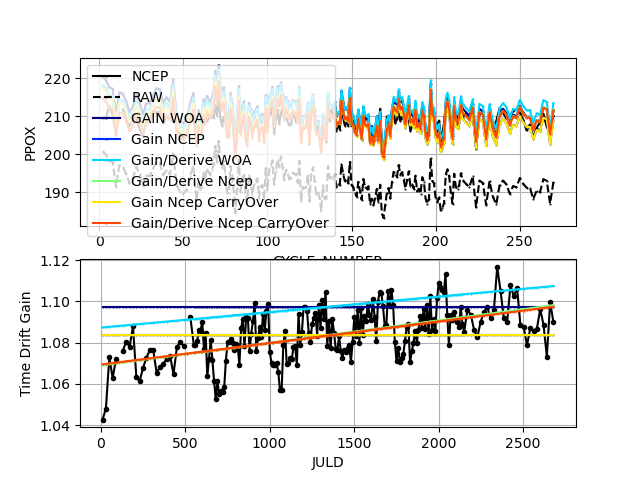

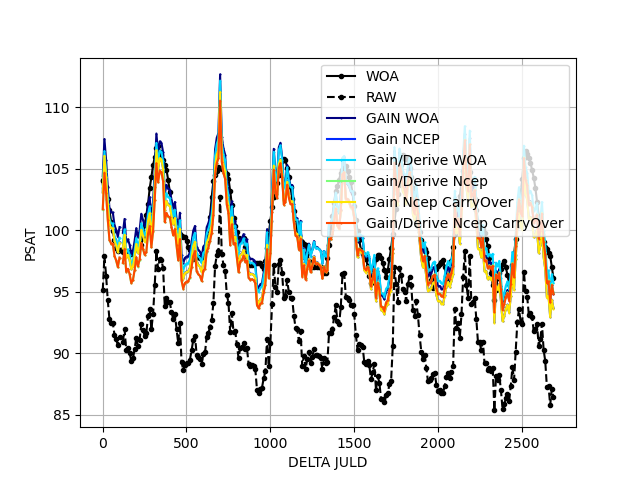

In [34]:
# Compare corrections
# User can change dict_corr.
# Example : dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP} compares Gain WOA Correction
# with Gain NCEP Correction.
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : params_Gain_NCEP_CarryOver,'Gain/Derive Ncep CarryOver' : params_Gain_Derive_NCEP_CarryOver}
breakpoint_list=[[]] * len(dict_corr)
_=plot_cmp_corr_NCEP(dict_corr,breakpoint_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_NCEP.png'))
_=plot_cmp_corr_WOA(dict_corr, breakpoint_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_PSATWOA.png'))


In [35]:
#breakpoint_list=[[1,2]] * len(dict_corr)
#print(breakpoint_list)
#print(type(breakpoint_list))
#toto=[[1,2],[5,3],[7,8,9]]
#print(toto)
#print(len(toto))
#print(toto[1])

# Piece wise Correction
If the user chooses a piece correction, that means there is a drift.
If the user wants a piece correction only with a simple gain, then he can process the soft with different first_cycle_to_use/last_cycle_to_use


## Number of pieces defined by the user

### WOA

In [36]:
def model_AXplusB(X,A,B):
    return (A*X + B)

In [37]:
# Number of piece to be defined by the user
nb_segment_WOA = 2

Breakpoints (X) : [1.38194444e+00 2.22028915e+03 2.68995486e+03]
Breaks : [1.38194444e+00 2.22028915e+03 2.68995486e+03]
Slopes : [4.69616540e-06 3.87714864e-05]
Intercepts : [1.08965291 1.01399585]


Correction WOA : Piece 1

Gain/Drift WOA calculated directly from PWLF module : 1.0896529105348032,0.15730700624211458
Gain/Drift WOA calculated with curve_fit : [1.08965291 0.15730701] error : [0.00219094 0.05701637]


Correction WOA : Piece 2

Gain/Drift WOA calculated directly from PWLF module : 1.013995845260174,1.3956262828187813
Gain/Drift WOA calculated with curve_fit : [1.01399585 1.39562628] error : [0.04090063 0.60026082]


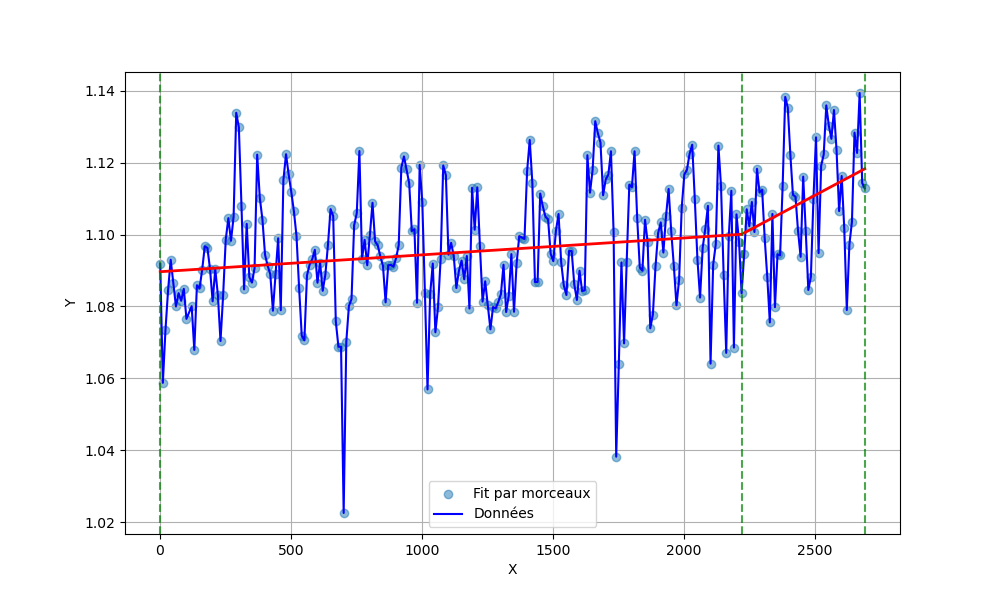

In [38]:
params_morceaux_Gain_Derive_WOA = []
perr_morceaux_Gain_Derive_WOA = []
bid = ppox_WOA_mean/ppox_ARGO_mean
mask = ~np.isnan(bid)
y_noisy = bid[mask]
x = delta_T_WOA[mask]


model = pwlf.PiecewiseLinFit(x, y_noisy)
model.fit(nb_segment_WOA)
breakpoints = model.fit_breaks  # Coordonnées X des breakpoints
print(f"Breakpoints (X) : {breakpoints}")
x_pred = delta_T_WOA
y_pred = model.predict(x_pred)

plt.figure(figsize=(10,6))
plt.scatter(x, y_noisy, label="Données bruitées", alpha=0.5)
plt.plot(x,y_noisy,'-b')
breaks_WOA = model.fit_breaks
slopes = model.slopes
intercepts = model.intercepts

print("Breaks :", model.fit_breaks)
print("Slopes :", model.slopes)
print("Intercepts :", model.intercepts)
# formule  = Y = Slopes * X + Intercept

for i in range(nb_segment_WOA):
    print(f"\n\nCorrection WOA : Piece {i+1}\n")
    x0, x1 = breaks_WOA[i], breaks_WOA[i+1]
    mask = (delta_T_WOA >=x0) & (delta_T_WOA<=x1)
    xs = delta_T_WOA[mask]            
    ys = slopes[i] * xs + intercepts[i]
    plt.plot(xs, ys, color="red", lw=2)
    slope_woa = intercepts[i]
    drift_woa = slopes[i] * 36500/slope_woa
    print(f"Gain/Drift WOA calculated directly from PWLF module : {slope_woa},{drift_woa}")

    # La version de pwlf ne permet pas d'avoir acces aux erreurs sur l'estimation de slope et intercept.
    # cov = model.calc_covariance() plante.
    # Pour contourner cela et obtenir une erreur, on passe par curve_fit.
    bid = ppox_WOA_mean/ppox_ARGO_mean
    popt, pcov = curve_fit(model_AXplusB, xs, bid[mask], p0=[1,0],nan_policy='omit')
    perr_bid_WOA = np.sqrt(np.diag(pcov))
    #print(f"popt : {popt}, error : {perr_bid_WOA}")

    perr_bid_WOA_final = perr_bid_WOA.copy()
    perr_bid_WOA_final[0] = perr_bid_WOA[1] # The error on slope_woa = error on intercepts (because slope_woa = intercepts[i])
    perr_bid_WOA_final[1] = 36500 * np.sqrt( (perr_bid_WOA[0] / intercepts[i])**2 + ((slopes[i] * perr_bid_WOA[1]) / (intercepts[i]**2))**2 ) # because drift_woa = slopes[i] * 36500/slope_woa

    initial_guess = [1, 0]  # Valeurs initiales pour G et D 
    mask = (delta_T_WOA >=x0) & (delta_T_WOA<=x1)
    xs = delta_T_WOA[mask]            # dense sur le segment
    ys = slopes[i] * xs + intercepts[i]
    var1_seg = ppox_ARGO_mean[mask]
    delta_T_seg = delta_T_WOA[mask]
    #val_bid1,covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ppox_WOA_mean[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
    #print(f"val_bid WOA1: {val_bid1}")
    val_bid,covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ys, p0=initial_guess,nan_policy='omit',full_output=True)
    #perr_bid = np.sqrt(np.diag(covariance))
    perr_morceaux_Gain_Derive_WOA.append(perr_bid_WOA_final)
    print(f"Gain/Drift WOA calculated with curve_fit : {val_bid} error : {perr_bid_WOA_final}")
    params_morceaux_Gain_Derive_WOA.append(val_bid)   
        
    
for b in breaks_WOA:
    plt.axvline(b, color="green", ls="--", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Fit par morceaux", "Données"])
plt.grid(True)
plt.show()

### NCEP

In [39]:
nb_segment_NCEP = 2

Breakpoints (X) : [  11.42         52.82911154 2680.16547454]
Breaks : [  11.42         52.82911154 2680.16547454]
Slopes : [7.54321217e-04 1.02230528e-05]
Intercepts : [1.03080172 1.07011176]


Correction NCEP : Piece 1

Gain/Drift NCEP calculated directly from PWLF module : 1.0308017176837947,26.710010208670823
Gain/Drift NCEP calculated with curve_fit : [ 1.03080172 26.71001021] error : [9.85650864e-03 9.87015643e+00]
Piece 1 lasts less than 90 days : No CarryOver Estimation
Gain/Drift NCEP calculated with curve_fit : [ 1.03080172 26.71001021] error : [9.85650864e-03 9.87015643e+00]


Correction NCEP : Piece 2

Gain/Drift NCEP calculated directly from PWLF module : 1.0701117625671892,0.34869388440707344
Gain/Drift NCEP calculated with curve_fit : [1.07011176 0.34869388] error : [0.00165098 0.0368443 ]
Piece 2 lasts more than 90 days : CarryOver Estimation
Gain/Drift NCEP CarryOver calculated with curve_fit : [1.07034291 0.14848626 0.33679822] error : [0.00140662 0.01431168 0.0319417

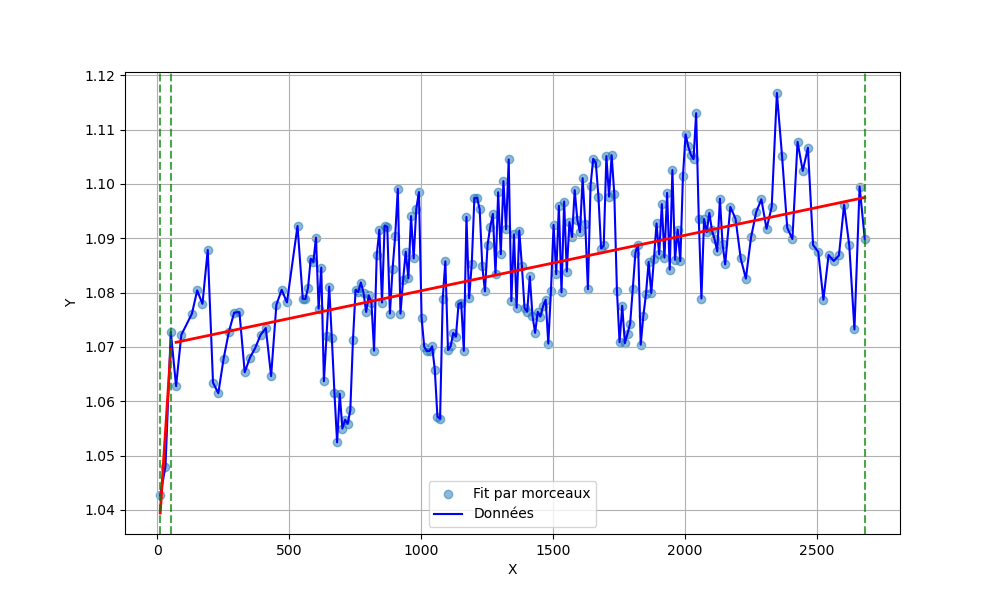

In [40]:
params_morceaux_Gain_Derive_NCEP = []
params_morceaux_Gain_Derive_CarryOver = []
perr_morceaux_Gain_Derive_NCEP = []
perr_morceaux_Gain_Derive_CarryOver = []

bid = NCEP_PPOX/PPOX1
mask = np.isfinite(bid)
y_noisy = bid[mask]
x = delta_T_NCEP[mask]

model = pwlf.PiecewiseLinFit(x, y_noisy)
model.fit(nb_segment_NCEP)

breakpoints = model.fit_breaks  # Coordonnées X des breakpoints
print(f"Breakpoints (X) : {breakpoints}")
x_pred = delta_T_NCEP
y_pred = model.predict(x_pred)


plt.figure(figsize=(10,6))
plt.scatter(x, y_noisy, label="Données bruitées", alpha=0.5)
plt.plot(x,y_noisy,'-b')
breaks_NCEP = model.fit_breaks
slopes = model.slopes
intercepts = model.intercepts

print("Breaks :", model.fit_breaks)
print("Slopes :", model.slopes)
print("Intercepts :", model.intercepts)
# formule  = Y = Slopes * X + Intercept


nb_day_carryover = 90
for i in range(nb_segment_NCEP):
    print(f"\n\nCorrection NCEP : Piece {i+1}\n")
    x0, x1 = breaks_NCEP[i], breaks_NCEP[i+1]
    mask = (delta_T_NCEP >=x0) & (delta_T_NCEP<=x1)
    xs = delta_T_NCEP[mask]            # dense sur le segment
    ys = slopes[i] * xs + intercepts[i]
    plt.plot(xs, ys, color="red", lw=2)
    slope_ncep = intercepts[i]
    drift_ncep = slopes[i] * 36500/slope_ncep
    print(f"Gain/Drift NCEP calculated directly from PWLF module : {slope_ncep},{drift_ncep}")


    # La version de pwlf ne permet pas d'avoir acces aux erreurs sur l'estimation de slope et intercept.
    # cov = model.calc_covariance() plante.
    # Pour contourner cela et obtenir une erreur, on passe par curve_fit.
    bid = NCEP_PPOX/dsair['PPOX_DOXY']
    popt, pcov = curve_fit(model_AXplusB, xs, bid[mask], p0=[1,0],nan_policy='omit')
    perr_bid_NCEP = np.sqrt(np.diag(pcov))
    
    var1_seg = PPOX1[mask]
    var2_seg = PPOX2[mask]
    delta_T_seg = delta_T_NCEP[mask]
    initial_guess = [1, 0]  # Valeurs initiales pour G et D 
    #val_bid1,covariance,info,mesg,ier= curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], NCEP_PPOX[mask]/var1_seg, p0=initial_guess,nan_policy='omit',full_output=True)
    #print(f"val_bid NCEP 1: {val_bid1}")
    #print(f"Erreur Gain/Derive NCEP : {np.sqrt(np.diag(covariance))}")

    val_bid_NCEP,covariance,info,mesg,ier= curve_fit(model_Gain_Derive, [var1_seg/var1_seg,delta_T_seg], ys, p0=initial_guess,nan_policy='omit',full_output=True)
    # perr_bid_NCEP = np.sqrt(np.diag(covariance)) # Les erreurs sont mal estimees (infimes voire nulles).
    
    #
    # Calcul de l'erreur sur slope et drift final.
    #
    perr_bid_NCEP_final = perr_bid_NCEP.copy()
    perr_bid_NCEP_final[0] = perr_bid_NCEP[1]
    perr_bid_NCEP_final[1] = 36500 * np.sqrt( (perr_bid_NCEP[0] / intercepts[i])**2 + ((slopes[i] * perr_bid_NCEP[1]) / (intercepts[i]**2))**2 )
    perr_morceaux_Gain_Derive_NCEP.append(perr_bid_NCEP_final)
    print(f"Gain/Drift NCEP calculated with curve_fit : {val_bid_NCEP} error : {perr_bid_NCEP_final}")



    params_morceaux_Gain_Derive_NCEP.append(val_bid_NCEP)

    if (breaks_NCEP[i+1]-breaks_NCEP[i]>nb_day_carryover):
        print(f"Piece {i+1} lasts more than {nb_day_carryover} days : CarryOver Estimation")
        initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
        val_bid_NCEP_CarryOver, covariance,info,mesg,ier = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],NCEP_PPOX[mask],p0=initial_guess,nan_policy='omit',full_output=True)
        #val_bid2, covariance,info,mesg,ier = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],ys*dsair['PPOX_DOXY'][mask],p0=initial_guess,nan_policy='omit',full_output=True)
        #print(f"val_bid NCEP CarryOver2: {val_bid2}")
        params_morceaux_Gain_Derive_CarryOver.append(val_bid_NCEP_CarryOver)  
        perr_bid_CarryOver = np.sqrt(np.diag(covariance))
        perr_morceaux_Gain_Derive_CarryOver.append(perr_bid_CarryOver)
        print(f"Gain/Drift NCEP CarryOver calculated with curve_fit : {val_bid_NCEP_CarryOver} error : {perr_bid_CarryOver}")


    else:
        print(f"Piece {i+1} lasts less than {nb_day_carryover} days : No CarryOver Estimation")
        print(f"Gain/Drift NCEP calculated with curve_fit : {val_bid_NCEP} error : {perr_bid_NCEP_final}")
        val_bid = np.array([val_bid_NCEP[0],0,val_bid_NCEP[1]])
        perr_bid = np.array([perr_bid_NCEP_final[0],0,perr_bid_NCEP_final[1]])
        params_morceaux_Gain_Derive_CarryOver.append(val_bid)   
        perr_morceaux_Gain_Derive_CarryOver.append(perr_bid)

        
    
for b in breaks_NCEP:
    plt.axvline(b, color="green", ls="--", alpha=0.7)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Fit par morceaux", "Données"])
plt.grid(True)
plt.show()

### Results creation

In [41]:
params_morceaux_Gain_Derive_NCEP = np.array(params_morceaux_Gain_Derive_NCEP)
params_morceaux_Gain_Derive_CarryOver = np.array(params_morceaux_Gain_Derive_CarryOver)
params_morceaux_Gain_Derive_CarryOver = params_morceaux_Gain_Derive_CarryOver[:, [0, 2]]
params_morceaux_Gain_Derive_WOA = np.array(params_morceaux_Gain_Derive_WOA)

perr_morceaux_Gain_Derive_NCEP = np.array(perr_morceaux_Gain_Derive_NCEP)
perr_morceaux_Gain_Derive_CarryOver = np.array(perr_morceaux_Gain_Derive_CarryOver)
perr_morceaux_Gain_Derive_CarryOver = perr_morceaux_Gain_Derive_CarryOver[:, [0, 2]]
perr_morceaux_Gain_Derive_WOA = np.array(perr_morceaux_Gain_Derive_WOA)

### Plots

Gain/Derive Piece WOA
Number of pieces : 2
[1.08965291 0.15730701]
[1.01399585 1.39562628]
Gain/Derive Piece Ncep
Number of pieces : 2
[ 1.03080172 26.71001021]
[1.07011176 0.34869388]
Gain/Derive Ncep Piece CarryOver
Number of pieces : 2
[ 1.03080172 26.71001021]
[1.07034291 0.33679822]
Gain/Derive Piece WOA
Number of pieces : 2
[1.08965291 0.15730701]
[1.01399585 1.39562628]
Gain/Derive Piece Ncep
Number of pieces : 2
[ 1.03080172 26.71001021]
[1.07011176 0.34869388]
Gain/Derive Ncep Piece CarryOver
Number of pieces : 2
[ 1.03080172 26.71001021]
[1.07034291 0.33679822]


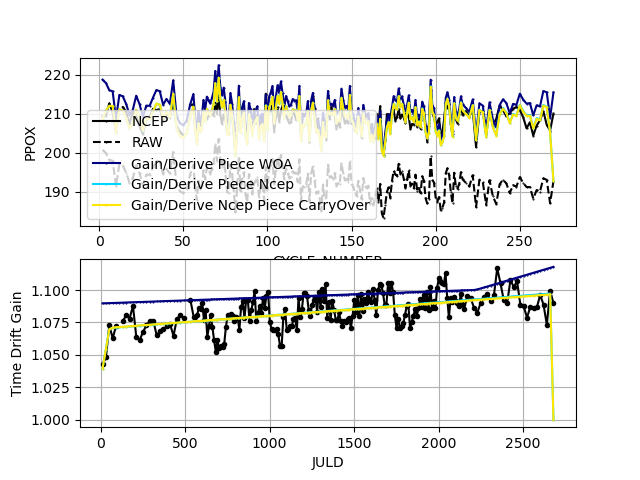

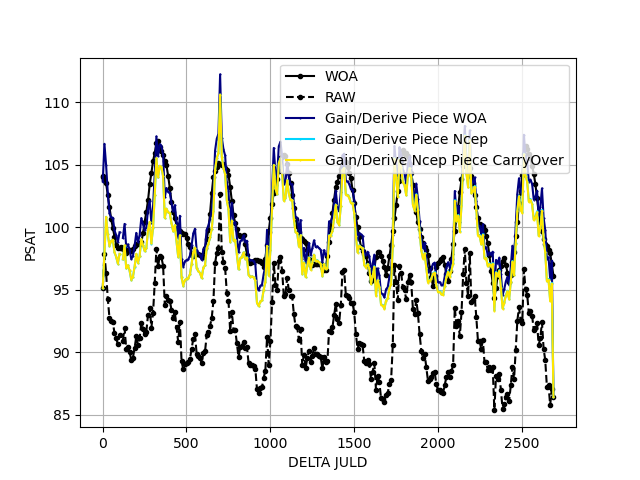

In [42]:
dict_corr = {'Gain/Derive Piece WOA' : params_morceaux_Gain_Derive_WOA,
             'Gain/Derive Piece Ncep' : params_morceaux_Gain_Derive_NCEP,'Gain/Derive Ncep Piece CarryOver' : params_morceaux_Gain_Derive_CarryOver}
breakpoint_list=[breaks_WOA,breaks_NCEP,breaks_NCEP]
_=plot_cmp_corr_NCEP(dict_corr,breakpoint_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_NCEP.png'))
_=plot_cmp_corr_WOA(dict_corr, breakpoint_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_PSATWOA.png'))

In [74]:
dict_corr = {'Gain/Derive Piece WOA' : np.stack((params_morceaux_Gain_Derive_WOA, perr_morceaux_Gain_Derive_WOA), axis=0),
             'Gain/Derive Piece Ncep' : np.stack((params_morceaux_Gain_Derive_NCEP,perr_morceaux_Gain_Derive_NCEP),axis=0),'Gain/Derive Ncep Piece CarryOver' : np.stack((params_morceaux_Gain_Derive_CarryOver,perr_morceaux_Gain_Derive_CarryOver),axis=0)}


def write_param_result(dict_corr):
    for index, (key, value) in enumerate(dict_corr.items()):
        print(key)
        param =  value
        nb_dim = param.ndim
        if nb_dim==2:
            nb_segment = 1
        elif nb_dim == 3:
            val_bid1,nb_segment,val_bid2 = param.shape
            
        print(f"Nb piece : {nb_segment}")

        if nb_segment == 1:
            if len(param[0]) == 1:
                gain = param[0,0]
                drift = 0
                egain = param[1,0]
                edrift = 0
            else:
                gain = param[0,0]
                drift = param[0,1]
                egain = param[1,0]
                edrift = param[1,1]

            print(f"Gain/Drift {gain:.4f}/{drift:.4f} with error {egain:.4f}/{edrift:.4f}")
                
        else:                      
            for i in range(nb_segment):
                gain, drift = param[0,i]
                egain,edrift = param[1,i]
                print(f"Piece {i+1}  : "
                      f"Gain/Drift {gain:.4f}/{drift:.4f} with error {egain:.4f}/{edrift:.4f}")


def write_param_result3(dict_corr,num_float,*args):
    line_tot = []
    if args:
        fic = args[0]
    else:
        fic = None


    print(fic)
    line_tot.append(num_float)
    
    for index, (key, value) in enumerate(dict_corr.items()):
        param =  value
        nb_dim = param.ndim
        if nb_dim==2:
            nb_segment = 1
        elif nb_dim == 3:
            val_bid1,nb_segment,val_bid2 = param.shape

        line_tot.append(key)
        line = f"Nb piece : {nb_segment}"
        line_tot.append(line)
        print('merdum1')
        print(nb_segment)
        print(nb_segment==1)

        if (nb_segment == 1):
            print('merdum merdum',param)
            if len(param[0]) == 1:
                gain = param[0,0]
                drift = 0
                egain = param[1,0]
                edrift = 0
                coef_pres = 0
                error_pres = 0
            else:
                gain = param[0,0]
                drift = param[0,1]
                egain = param[1,0]
                edrift = param[1,1]
                if len(param[0])==3:
                    coef_pres = param[0,2]
                    error_pres = param[1,2]
                else:
                    coef_pres = 0
                    error_pres = 0

            line = f"Gain/Drift/Pressure {gain:.4f}/{drift:.4f}/{coef_pres:.4f} with error {egain:.4f}/{edrift:.4f}/{error_pres:.4f}"
            line_tot.append(line)

        else:                      
            for i in range(nb_segment):
                gain, drift,*coef_pres = param[0,i]
                egain,edrift,*error_pres = param[1,i]
                if len(coef_pres)==0:
                    coef_pres = 0
                    error_pres = 0
                else:
                    coef_pres = coef_pres[0]
                    error_pres = error_pres[0]
                line = f"Piece {i+1}  : "f"Gain/Drift/Pressure {gain:.4f}/{drift:.4f}/{coef_pres:.4f} with error {egain:.4f}/{edrift:.4f}/{error_pres:.4f}"
                line_tot.append(line)
        
    if fic is None:
        for line in line_tot:
                print(line)
    else:
        print('ecriture fichier')
        with open(fic, 'w') as f:
            for line in line_tot:
                f.write(line + '\n')


dict_corr = {'Gain/Derive Piece WOA' : np.stack((params_morceaux_Gain_Derive_WOA, perr_morceaux_Gain_Derive_WOA), axis=0),
             'Gain/Derive Piece Ncep' : np.stack((params_morceaux_Gain_Derive_NCEP,perr_morceaux_Gain_Derive_NCEP),axis=0),'Gain/Derive Ncep Piece CarryOver' : np.stack((params_morceaux_Gain_Derive_CarryOver,perr_morceaux_Gain_Derive_CarryOver),axis=0),
            'Gain/Derive Ncep':np.stack((params_Gain_Derive_NCEP,perr_Gain_Derive_NCEP),axis=0),'Gain NCEP':np.stack((params_Gain_NCEP,perr_Gain_NCEP),axis=0)}
write_param_result3(dict_corr,num_float)




None
merdum1
2
False
merdum1
2
False
merdum1
2
False
merdum1
1
True
merdum merdum [[1.06898082 0.37180505]
 [0.00162453 0.03705413]]
merdum1
1
True
merdum merdum [[1.08379476e+00]
 [8.77239977e-04]]
6902807
Gain/Derive Piece WOA
Nb piece : 2
Piece 1  : Gain/Drift/Pressure 1.0897/0.1573/0.0000 with error 0.0022/0.0570/0.0000
Piece 2  : Gain/Drift/Pressure 1.0140/1.3956/0.0000 with error 0.0409/0.6003/0.0000
Gain/Derive Piece Ncep
Nb piece : 2
Piece 1  : Gain/Drift/Pressure 1.0308/26.7100/0.0000 with error 0.0099/9.8702/0.0000
Piece 2  : Gain/Drift/Pressure 1.0701/0.3487/0.0000 with error 0.0017/0.0368/0.0000
Gain/Derive Ncep Piece CarryOver
Nb piece : 2
Piece 1  : Gain/Drift/Pressure 1.0308/26.7100/0.0000 with error 0.0099/9.8702/0.0000
Piece 2  : Gain/Drift/Pressure 1.0703/0.3368/0.0000 with error 0.0014/0.0319/0.0000
Gain/Derive Ncep
Nb piece : 1
Gain/Drift/Pressure 1.0690/0.3718/0.0000 with error 0.0016/0.0371/0.0000
Gain NCEP
Nb piece : 1
Gain/Drift/Pressure 1.0838/0.0000/0.0000 wit

### The user must decide which correction to apply

In [75]:
# Which correction to keep/apply
# Here, the user must decide which correction to keep to estimate a supplement gain with CTD.
# 
# corr_to_keep = 1 ==> WOA GAIN
# corr_to_keep = 2 ==> WOA Gain/Drift
# corr_to_keep = 3 ==> NCEP Gain without CarryOver
# corr_to_keep = 4 ==> NCEP Gain with CarryOver
# corr_to_keep = 5 ==> NCEP Gain/Drift without CarryOver
# corr_to_keep = 6 ==> NCEP Gain/Drift with CarryOver

breaks_to_keep = np.array([min(delta_T_Sprof),max(delta_T_Sprof)])
corr_to_keep = 2
match corr_to_keep:
    case 1:
        params_to_keep = copy.deepcopy(params_Gain_WOA)
        comment_corr = 'Correction with a WOA Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_WOA)
        nb_param = 1
    case 2:
        params_to_keep = copy.deepcopy(params_Gain_Derive_WOA)
        comment_corr = 'Correction with a WOA Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_WOA)
        nb_param = 2
    case 3:
        params_to_keep = copy.deepcopy(params_Gain_NCEP)
        comment_corr = 'Correction with a NCEP Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_NCEP)
        nb_param = 1
    case 4:
        params_to_keep = copy.deepcopy(params_Gain_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain'
        perr_to_keep = perr_Gain_NCEP_CarryOver[0]
        nb_param = 1
    case 5:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP)
        comment_corr = 'Correction with a NCEP Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_NCEP)
        nb_param = 2
    case 6:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain/Drift'
        perr_to_keep = perr_Gain_Derive_NCEP_CarryOver[[0,2]]
        nb_param = 2
    
    case 7 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_NCEP)
        comment_corr = 'Correction by piece with a NCEP  Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_NCEP
        nb_param = 2
        breaks_to_keep = breaks_NCEP

    case 8 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_CarryOver)
        comment_corr = 'Correction by piece with a NCEP CarryOver Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_CarryOver
        nb_param = 2
        breaks_to_keep = breaks_NCEP


    case 9 :
        params_to_keep = copy.deepcopy(params_morceaux_Gain_Derive_WOA)
        comment_corr = 'Correction with a WOA Gain/Drift'
        perr_to_keep = perr_morceaux_Gain_Derive_WOA
        nb_param = 2
        breaks_to_keep = breaks_WOA

print(comment_corr)
print(f'Correction used :  {params_to_keep}')
print(f'Error on correction : {perr_to_keep}')
print(f'breakpoint : {breaks_to_keep}')

nb_segment = len(breaks_to_keep)-1

Correction with a WOA Gain/Drift
Correction used :  [1.08726857 0.25269017]
Error on correction : [0.00199966 0.04336758]
breakpoint : [1.19444444e-01 2.68995486e+03]


### Supplement gain estimation from CTD

param_ok : [1.08726857 0.25269017]
[0.98567532] [0.00077034]
[0.98476007] [0.00094429]
Supplement Gain from CTD (without effect pressure) :  0.9857


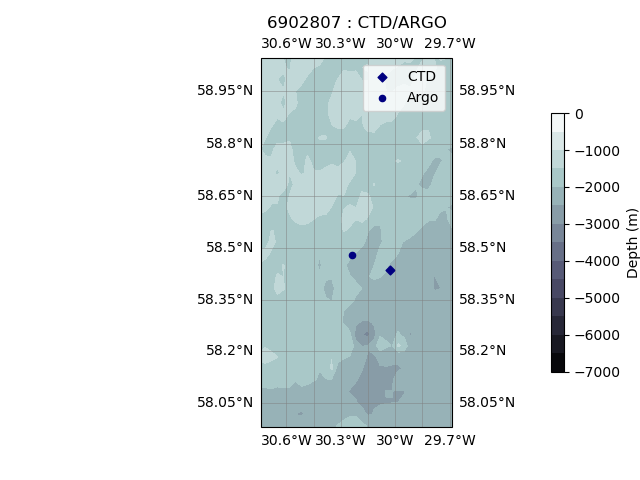

In [76]:
# We estimate a supplement Gain from the CTD without pressure effect.
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
perr_Gain_CTD = np.array([0])
ppox_cruise_tot = np.array([])
doxy_cruise_tot = np.array([])
ppox_cycle_corr_tot = np.array([])
doxy_cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])

# Compare ARGO Profil  with  CTD. We compare OXYGEN directly
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        _=plot_CTD_Argo_Pos(ds_argo_Sprof, ds_bathy,depths,extend_lon_lat,rep_ctd,fic_ctd,num_ctd,num_cycle)
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_CTD_argo.png'))

        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)

        ana_dens_cruise = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_cruise_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens_cruise[0])
        ppox_cruise = O2ctoO2p(O2_cruise_umolL,ds_cruise['TEMP'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0)) # On calcule PPOX pour P=0
        ppox_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        doxy_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))
        ppox_cruise_tot = np.concatenate((ppox_cruise_tot,ppox_cruise_interp),axis=None)
        doxy_cruise_tot = np.concatenate((doxy_cruise_tot,doxy_cruise_interp),axis=None)
        
        delta_T_Sprof_en_cours = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof_en_cours,(1,len(ds_cycle['N_LEVELS'])))

        if nb_segment>1:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof_en_cours)
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep
            

        print(f'param_ok : {params_ok}')

        ana_dens_cycle = sw.pden(ds_cycle['PSAL_ADJUSTED'],ds_cycle['TEMP_ADJUSTED'],ds_cycle['PRES_ADJUSTED'],0)
        O2_cycle_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens_cycle[0])
        ppox_cycle = O2ctoO2p(O2_cycle_umolL,ds_cycle['TEMP_ADJUSTED'].isel(N_PROF=0),ds_cycle['PSAL_ADJUSTED'].isel(N_PROF=0),ds_cycle['PRES_ADJUSTED'].isel(N_PROF=0)) # On calcule PPOX pour P=0
        if nb_param == 1:
            ppox_cycle_corr = model_Gain(ppox_cycle,*params_ok)
            doxy_cycle_corr = model_Gain(ds_cycle['DOXY'],*params_ok)
        else:
            ppox_cycle_corr = model_Gain_Derive([ppox_cycle,tab_delta_T],*params_ok)
            doxy_cycle_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_ok)


        ppox_cycle_corr_tot = np.concatenate((ppox_cycle_corr_tot,ppox_cycle_corr),axis=None)
        doxy_cycle_corr_tot = np.concatenate((doxy_cycle_corr_tot,doxy_cycle_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)
 
    
    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD_V2, covariance = curve_fit(model_Gain, ppox_cycle_corr_tot, ppox_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD_V2 = np.sqrt(np.diag(covariance))

    params_Gain_CTD, covariance = curve_fit(model_Gain, doxy_cycle_corr_tot, doxy_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD = np.sqrt(np.diag(covariance))
    
    print(params_Gain_CTD,perr_Gain_CTD)
    print(params_Gain_CTD_V2,perr_Gain_CTD_V2)

    print("Supplement Gain from CTD (without effect pressure) : ",",".join(f"{val:.4f}" for val in params_Gain_CTD))

### Supplement Gain and effect pressure estimation from CTD
# We estimate the effect pressure and the gain simultaneously

[1.08726857 0.25269017]
param_ok : [1.08726857 0.25269017]
Pressure effect Estimation
CTD pressure effect estimated with pressure effect : 0.041534 with error 0.000808
CTD Gain estimated with pressure effect : 0.988267 with error 0.000981
CTD pressure effect (PPOX)  estimated with pressure effect : 0.012980 with error 0.002457
CTD Gain estimated (PPOX) with pressure effect : 1.021136 with error 0.003225
dim : (1, 2012)


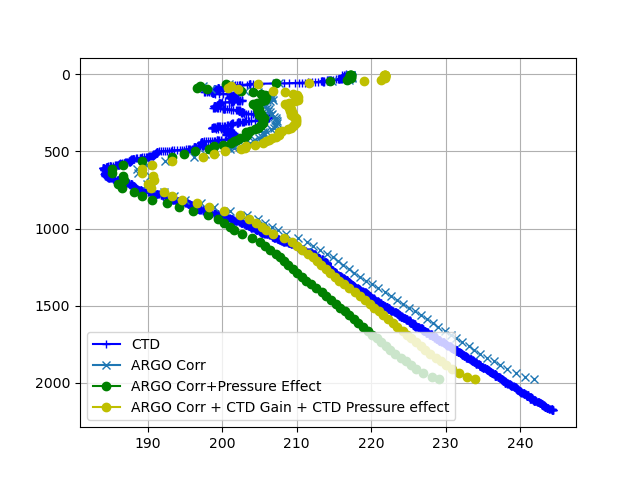

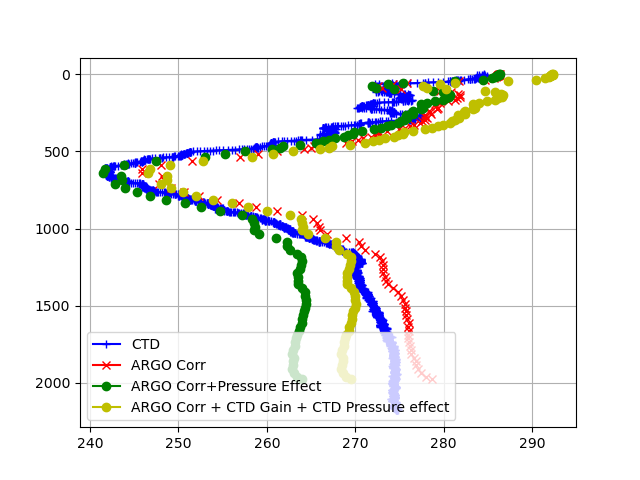

In [81]:
from scipy.interpolate import interp1d

# We estimate a pressure effect by using potentaol temperature.
# Init Pressure correction (0 by default) and a supplement gain from CTD (1 by default)
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])
perr_pressure = np.array([0,0])

print(params_to_keep)
# Pressure effect estimation.
# We compare ARGO O2 with CTD O2.
# According to V. Thierry, we must estimate a Gain and a pressure effect.
# Estimate only a pressure effect seems to be incorrect.
# We do thatfrom the 'first' correction.
strvar = '_ADJUSTED'
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        delta_T_Sprof_en_cours = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof_en_cours,(1,len(ds_cycle['N_LEVELS'])))

        if nb_segment>1:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof_en_cours)
            if index > 0:
                index = index -1
            params_ok = params_to_keep[index,:]
        else:
            params_ok = params_to_keep
            

        print(f'param_ok : {params_ok}')


        ana_dens_cruise = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_cruise_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens_cruise[0])
        ppox_cruise = O2ctoO2p(O2_cruise_umolL,ds_cruise['TEMP'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0)) # On calcule PPOX pour P=0

        ana_dens_cycle = sw.pden(ds_cycle['PSAL_ADJUSTED'],ds_cycle['TEMP_ADJUSTED'],ds_cycle['PRES_ADJUSTED'],0)
        O2_cycle_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens_cycle[0])
        ppox_cycle = O2ctoO2p(O2_cycle_umolL,ds_cycle['TEMP_ADJUSTED'].isel(N_PROF=0),ds_cycle['PSAL_ADJUSTED'].isel(N_PROF=0),ds_cycle['PRES_ADJUSTED'].isel(N_PROF=0)) # On calcule PPOX pour P=0
        if nb_param == 1:
            ppox_cycle_corr = model_Gain(ppox_cycle,*params_ok)
            doxy_cycle_corr = model_Gain(ds_cycle['DOXY'],*params_ok)
        else:
            ppox_cycle_corr = model_Gain_Derive([ppox_cycle,tab_delta_T],*params_ok)
            doxy_cycle_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_ok)


        # Compute ARGO and CTD theta.
        psal_cycle = ds_cycle['PSAL'+strvar].values
        pres_cycle = ds_cycle['PRES'+strvar].values 
        temp_cycle = ds_cycle['TEMP'+strvar].values
        theta_cycle = sw.ptmp(psal_cycle,temp_cycle,pres_cycle,0)

        psal_cruise = ds_cruise['PSAL'].values
        pres_cruise = ds_cruise['PRES'].values
        temp_cruise = ds_cruise['TEMP'].values
        theta_cruise = sw.ptmp(psal_cruise,temp_cruise,pres_cruise,0)

       

        theta_common = np.linspace(max(np.nanmin(theta_cycle), np.nanmin(theta_cruise)),
                                   min(np.nanmax(theta_cycle), np.nanmax(theta_cruise)),
                                   500)

        valid = ~np.isnan(theta_cycle[0]) & ~np.isnan(doxy_cycle_corr[0])
        # Defintion fonction interpolation.
        interp_o2_cycle = interp1d(theta_cycle[0][valid], doxy_cycle_corr[0][valid], bounds_error=False, fill_value=np.nan)
        interp_ppox_cycle = interp1d(theta_cycle[0][valid], ppox_cycle_corr[0][valid], bounds_error=False, fill_value=np.nan)
        interp_o2_cruise = interp1d(theta_cruise[0], ds_cruise['OXYK'][0], bounds_error=False, fill_value=np.nan)
        interp_ppox_cruise = interp1d(theta_cruise[0], ppox_cruise[0], bounds_error=False, fill_value=np.nan)
        interp_pres_cycle = interp1d(theta_cycle[0], pres_cycle[0], bounds_error=False, fill_value=np.nan)
        interp_temp_cycle = interp1d(theta_cycle[0], temp_cycle[0], bounds_error=False, fill_value=np.nan)

        
        # Interpolation on theta communs entre CTD and ARGO
        o2_cycle_theta = interp_o2_cycle(theta_common)
        ppox_cycle_theta = interp_ppox_cycle(theta_common)
        o2_cruise_theta = interp_o2_cruise(theta_common)
        ppox_cruise_theta = interp_ppox_cruise(theta_common)
        p_cycle_theta = interp_pres_cycle(theta_common)
        temp_cycle_theta = interp_temp_cycle(theta_common)

        # Remove Nan Values
        valid = ~np.isnan(o2_cycle_theta) & ~np.isnan(o2_cruise_theta) & ~np.isnan(p_cycle_theta)
        o2_cycle_theta = o2_cycle_theta[valid]
        ppox_cycle_theta = ppox_cycle_theta[valid]
        o2_cruise_theta = o2_cruise_theta[valid]
        ppox_cruise_theta = ppox_cruise_theta[valid]
        p_cycle_theta = p_cycle_theta[valid]
        temp_cycle_theta = temp_cycle_theta[valid]
        theta_common = theta_common[valid]

        
        PRES_1D = p_cycle_theta.squeeze()  
        mask = PRES_1D >= pressure_threshold
        pres_pour_pres = p_cycle_theta[mask]
        temp_pour_pres = temp_cycle_theta[mask]
        doxy_cruise_pour_pres = o2_cruise_theta[mask]
        ppox_cruise_pour_pres = ppox_cruise_theta[mask]
        doxy_cycle_pour_pres = o2_cycle_theta[mask]
        ppox_cycle_pour_pres = ppox_cycle_theta[mask]

        #plt.figure()
        #plt.plot(doxy_cruise_pour_pres,theta_common[mask],'+b')
        #plt.plot(doxy_cycle_pour_pres,theta_common[mask],'xr')
        #plt.figure()
        #plt.plot(ppox_cruise_pour_pres,theta_common[mask],'+b')
        #plt.plot(ppox_cycle_pour_pres,theta_common[mask],'xr')


       
       
        print('Pressure effect Estimation')
        initial_guess = [1,0]   
        #params_corr_pressure, covariance = curve_fit(model_corr_pres, [(cycle_pour_pres*doxy_cruise_mean/doxy_argo_mean)[0].values,pres_pour_pres[0].values], oxy_pour_pres, p0=initial_guess,nan_policy='omit') 
        #params_corr_pressure, covariance = curve_fit(model_Gain_pres, [doxy_cycle_pour_pres,pres_pour_pres], doxy_cruise_pour_pres, p0=initial_guess,nan_policy='omit') 
        params_corr_pressure, covariance = curve_fit(lambda X, G, Gp: model_Gain_pres(X, G, Gp, pcoef2, pcoef3),
                       [doxy_cycle_pour_pres,pres_pour_pres,temp_pour_pres], doxy_cruise_pour_pres, p0=initial_guess,nan_policy='omit')
        perr_pressure = np.sqrt(np.diag(covariance))
        print(f'CTD pressure effect estimated with pressure effect : {params_corr_pressure[1]:.6f} with error {perr_pressure[1]:.6f}')
        print(f'CTD Gain estimated with pressure effect : {params_corr_pressure[0]:.6f} with error {perr_pressure[0]:.6f}')

        params_corr_pressure, covariance = curve_fit(lambda X, G, Gp: model_Gain_pres(X, G, Gp, pcoef2, pcoef3),
                       [ppox_cycle_pour_pres,pres_pour_pres,temp_pour_pres], ppox_cruise_pour_pres, p0=initial_guess,nan_policy='omit')
        perr_pressure = np.sqrt(np.diag(covariance))
        print(f'CTD pressure effect (PPOX)  estimated with pressure effect : {params_corr_pressure[1]:.6f} with error {perr_pressure[1]:.6f}')
        print(f'CTD Gain estimated (PPOX) with pressure effect : {params_corr_pressure[0]:.6f} with error {perr_pressure[0]:.6f}')
        print('dim :',ppox_cycle_corr.shape)
        plt.figure()
        h1 = plt.plot(ppox_cruise[0],ds_cruise['PRES'][0],'+-b')
        h2 = plt.plot(ppox_cycle_corr[0],ds_cycle['PRES'][0],'x-')
        h3=plt.plot(ppox_cycle_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP'][0]+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+ params_corr_pressure[1])*ds_cycle['PRES'][0]/1000),ds_cycle['PRES'][0],'o-g')  
        h4=plt.plot(ppox_cycle_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP'][0]+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+params_corr_pressure[1])*ds_cycle['PRES'][0]/1000)*params_corr_pressure[0],ds_cycle['PRES'][0],'o-y')        
        plt.gca().invert_yaxis()
        plt.grid()
        _=plt.legend([h1[0],h2[0],h3[0], h4[0]],['CTD','ARGO Corr','ARGO Corr+Pressure Effect','ARGO Corr + CTD Gain + CTD Pressure effect'])

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],ds_cruise['PRES'][0],'+-b')
        h2 = plt.plot(doxy_cycle_corr[0],ds_cycle['PRES'][0],'x-r')
        h3=plt.plot(doxy_cycle_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+ params_corr_pressure[1])*ds_cycle['PRES'][0]/1000),ds_cycle['PRES'][0],'o-g')  
        h4=plt.plot(doxy_cycle_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+params_corr_pressure[1])*ds_cycle['PRES'][0]/1000)*params_corr_pressure[0],ds_cycle['PRES'][0],'o-y')        
        plt.gca().invert_yaxis()
        plt.grid()
        _=plt.legend([h1[0],h2[0],h3[0], h4[0]],['CTD','ARGO Corr','ARGO Corr+Pressure Effect','ARGO Corr + CTD Gain + CTD Pressure effect'])

        params_Gain_CTD_with_pressure = np.array([params_corr_pressure[0]])
        params_corr_pressure = np.array([params_corr_pressure[1]])


In [82]:
# Compute final correction with or without pressure effect.
print(perr_to_keep)
perr_final = perr_to_keep.copy()
derive_final = 0
if nb_param == 1:
    if nb_segment==1:
        perr_final = np.append(perr_final, 0) # error on drift
        perr_final = np.append(perr_final, 0) # error on pressure effect
    else: # On ne passe jamais la. Si plusieurs segments, alors on estime gain et derive, donc nb_param>1
        zeros_column = np.zeros((perr_final.shape[0], 2))  # Créer une colonne de zéros
        perr_final = np.hstack((perr_final, zeros_column)) 
else :
    if nb_segment==1:
        derive_final = params_to_keep[1]
        perr_final = np.append(perr_final, 0) # error on pressure effect
    else:
        zeros_column = np.zeros((perr_final.shape[0], 1))  # Créer une colonne de zéros
        perr_final = np.hstack((perr_final, zeros_column)) 
        derive_final = params_to_keep[:,1]

print(perr_to_keep)
print(perr_final)

[0.00199966 0.04336758]
[0.00199966 0.04336758]
[0.00199966 0.04336758 0.        ]


In [83]:
if nb_segment==1:
    corr_final_without_pressure_correction = np.array([params_to_keep[0],derive_final,params_no_corr_pressure[0]])
    corr_final_with_pressure_correction = np.array([params_to_keep[0],derive_final,params_corr_pressure[0]])
    corr_final_CTD_without_pressure_correction = np.array([params_Gain_CTD[0] * params_to_keep[0],derive_final,params_no_corr_pressure[0]])
    corr_final_CTD_with_pressure_correction = np.array([params_Gain_CTD_with_pressure[0] * params_to_keep[0],derive_final,params_corr_pressure[0]])
    perr_final_pressure = perr_final.copy()
    perr_final_pressure[2] = perr_pressure[1] # correction to keep with pressure effect
    perr_final_CTD = [np.sqrt(perr_final[0]*perr_final[0] + perr_Gain_CTD[0]*perr_Gain_CTD[0]),perr_final[1],perr_final[2]] # correction to keep with CTD supplement Gain
    perr_final_CTD_with_pressure = [np.sqrt(perr_final[0]*perr_final[0] + perr_pressure[0]*perr_pressure[0]),perr_final[1],perr_final[1]] # correction to keep with CTD effect pressure and CTD Gain
else :
    corr_final_without_pressure_correction = np.append(params_to_keep, np.zeros((params_to_keep.shape[0],1)), axis=1) # Ajout colonne de 0 pour effet de pression
    corr_final_with_pressure_correction = np.append(params_to_keep, np.full((params_to_keep.shape[0],1),params_corr_pressure[0]), axis=1)
    corr_final_CTD_without_pressure_correction = corr_final_without_pressure_correction.copy()
    corr_final_CTD_without_pressure_correction[:,0] = corr_final_CTD_without_pressure_correction[:,0] * params_Gain_CTD[0]
    corr_final_CTD_with_pressure_correction = corr_final_with_pressure_correction.copy()
    corr_final_CTD_with_pressure_correction[:,0] = corr_final_CTD_with_pressure_correction[:,0] * params_Gain_CTD[0]

    perr_final_pressure = perr_final.copy()
    perr_final_pressure[:,2] = perr_pressure[1]
    perr_final_CTD = perr_final.copy()
    perr_final_CTD[:,0] = np.sqrt(perr_final_CTD[:,0]*perr_final_CTD[:,0] + perr_Gain_CTD[0]*perr_Gain_CTD[0]) # correction to keep with CTD supplement Gain
    perr_final_CTD_with_pressure = perr_final_pressure.copy()
    perr_final_CTD_with_pressure[:,0] = np.sqrt(perr_final_CTD_with_pressure[:,0]*perr_final_CTD_with_pressure[:,0] + perr_pressure[0]*perr_pressure[0]) # correction to keep with CTD effect pressure and CTD Gain
    
    

In [84]:
def write_param_result2(dict_corr):
    for index, (key, value) in enumerate(dict_corr.items()):
        print(key)
        param =  value
        nb_dim = param.ndim
        if nb_dim==2:
            nb_segment = 1
        elif nb_dim == 3:
            val_bid1,nb_segment,val_bid2 = param.shape
            
        print(f"Nb piece : {nb_segment}")

        if nb_segment == 1:
            if len(param[0]) == 1:
                gain = param[0,0]
                drift = 0
                egain = param[1,0]
                edrift = 0
                coef_pres = 0
                eroor_pres = 0
            else:
                gain = param[0,0]
                drift = param[0,1]
                egain = param[1,0]
                edrift = param[1,1]
                if len(param[0]==3):
                    coef_pres = param[0,2]
                    error_pres = param[1,2]
                else:
                    coef_pres = 0
                    error_pres = 0

            print(f"Gain/Drift/Pressure {gain:.4f}/{drift:.4f}/{coef_pres:.4f} with error {egain:.4f}/{edrift:.4f}/{error_pres:.4f}")
                
        else:                      
            for i in range(nb_segment):
                gain, drift,*coef_pres = param[0,i]
                egain,edrift,*error_pres = param[1,i]
                if len(coef_pres)==0:
                    coef_pres = 0
                    error_pres = 0
                else:
                    coef_pres = coef_pres[0]
                    error_pres = error_pres[0]
                print(f"Piece {i+1}  : "
                      f"Gain/Drift/Pressure {gain:.4f}/{drift:.4f}/{coef_pres:.4f} with error {egain:.4f}/{edrift:.4f}/{error_pres:.4f}")

dict_corr = {'Corr1' : np.stack((corr_final_without_pressure_correction, perr_final), axis=0),
             'Corr2' : np.stack((corr_final_with_pressure_correction,perr_final_pressure),axis=0),'corr3' : np.stack((corr_final_CTD_without_pressure_correction,perr_final_CTD),axis=0),
             'Corr4' : np.stack((corr_final_CTD_with_pressure_correction,perr_final_CTD_with_pressure),axis=0)}

write_param_result2(dict_corr)

Corr1
Nb piece : 1
Gain/Drift/Pressure 1.0873/0.2527/0.0000 with error 0.0020/0.0434/0.0000
Corr2
Nb piece : 1
Gain/Drift/Pressure 1.0873/0.2527/0.0130 with error 0.0020/0.0434/0.0025
corr3
Nb piece : 1
Gain/Drift/Pressure 1.0717/0.2527/0.0000 with error 0.0021/0.0434/0.0000
Corr4
Nb piece : 1
Gain/Drift/Pressure 1.1102/0.2527/0.0130 with error 0.0038/0.0434/0.0434


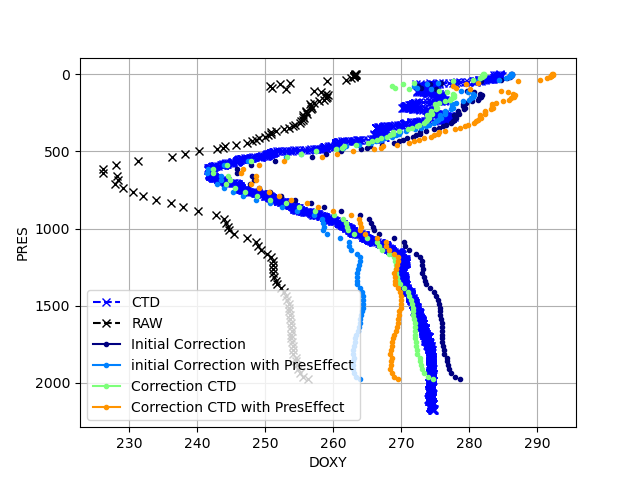

In [89]:
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        delta_T_Sprof_en_cours = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        if nb_segment>1:
            #index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            #index = index - 1
            index = next(x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_Sprof_en_cours)
            if index > 0:
                index = index -1
            dict_corr = {'Initial Correction' : corr_final_without_pressure_correction[index,:],'initial Correction with PresEffect' : corr_final_with_pressure_correction[index,:],'Correction CTD' : corr_final_CTD_without_pressure_correction[index,:],
                     'Correction CTD with PresEffect' : corr_final_CTD_with_pressure_correction[index,:]}
        else:
            dict_corr = {'Initial Correction' : corr_final_without_pressure_correction,'initial Correction with PresEffect' : corr_final_with_pressure_correction,'Correction CTD' : corr_final_CTD_without_pressure_correction,
                     'Correction CTD with PresEffect' : corr_final_CTD_with_pressure_correction}
            
        
        _=plot_cmp_ARGO_CTD(ds_cruise,ds_cycle,dict_corr,launch_date,pcoef2,pcoef3) 
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_differents_corr_with_CTD.png'))

        

# Choose between 4 corrections 
- Initial correction
- Intial correction with CTD gain
- Initial correction with pressure effect
- Initial correction with CTD gain and pressure effect

In [90]:
#
# Which correction to apply (without or with pressure correction).
#
corr_to_apply  = 4
if corr_to_apply == 1:
    corr_final_to_use = corr_final_without_pressure_correction
    perr_to_use = perr_final
elif corr_to_apply == 2 :
    corr_final_to_use = corr_final_with_pressure_correction
    comment_corr = comment_corr + ' and a pressure effect'
    perr_to_use = perr_final_pressure
elif corr_to_apply == 3:
    corr_final_to_use = corr_final_CTD_without_pressure_correction
    coment_corr = comment_corr + ' and CTD Gain'
    perr_to_use = perr_final_CTD

else:
    corr_final_to_use = corr_final_CTD_with_pressure_correction
    comment_corr = comment_corr + ' and CTD Gain and pressure effect'
    perr_to_use = perr_final_CTD_with_pressure


print(comment_corr)
print(corr_final_to_use)
print(perr_to_use)

Correction with a WOA Gain/Drift and CTD Gain and pressure effect
[1.11024899 0.25269017 0.01297975]
[0.003794262306677538, 0.04336758160914241, 0.04336758160914241]


In [95]:
def write_param_result3(dict_corr,num_float,*args):
    line_tot = []
    if args:
        fic = args[0]
    else:
        fic = None


    print(fic)
    line_tot.append(num_float)
    for index, (key, value) in enumerate(dict_corr.items()):
        param =  value
        nb_dim = param.ndim
        if nb_dim==2:
            nb_segment = 1
        elif nb_dim == 3:
            val_bid1,nb_segment,val_bid2 = param.shape

        line_tot.append(key)
        line = f"Nb piece : {nb_segment}"
        line_tot.append(line)
        

        if nb_segment == 1:
            if len(param[0]) == 1:
                gain = param[0,0]
                drift = 0
                egain = param[1,0]
                edrift = 0
                coef_pres = 0
                error_pres = 0
            else:
                gain = param[0,0]
                drift = param[0,1]
                egain = param[1,0]
                edrift = param[1,1]
                if len(param[0]==3):
                    coef_pres = param[0,2]
                    error_pres = param[1,2]
                else:
                    coef_pres = 0
                    error_pres = 0

            line = f"Gain/Drift/Pressure {gain:.4f}/{drift:.4f}/{coef_pres:.4f} with error {egain:.4f}/{edrift:.4f}/{error_pres:.4f}"
            line_tot.append(line)

        else:                      
            for i in range(nb_segment):
                gain, drift,*coef_pres = param[0,i]
                egain,edrift,*error_pres = param[1,i]
                if len(coef_pres)==0:
                    coef_pres = 0
                    error_pres = 0
                else:
                    coef_pres = coef_pres[0]
                    error_pres = error_pres[0]
                line = f"Piece {i+1}  : "f"Gain/Drift/Pressure {gain:.4f}/{drift:.4f}/{coef_pres:.4f} with error {egain:.4f}/{edrift:.4f}/{error_pres:.4f}"
                line_tot.append(line)
        
    if fic is None:
        for line in line_tot:
                print(line)
    else:
        print('ecriture fichier')
        with open(fic, 'w') as f:
            for line in line_tot:
                f.write(line + '\n')


In [98]:
def plot_cmp_corr_NCEP_with_error2(dict_corr : dict,  list_pieceT : list, dsair : xr.Dataset,ncep_data : np.ndarray,delta_T : np.ndarray) -> None:
    """ Function to compare different PPOX dsair correction

    Parameters
    ----------
    dict_corr : dict
        dict of Correction (Name/Value).
    perr_to_use : np.ndarray
        error for correction
    list_pieceT : list
        list of time to cut the correction in piece.
        same length as dict_corr.
    dsair : xr.Dataset
        Contains InAir data
    ncep_data : np.ndarray
        NCEP PPOX
    delta_T : np.ndarray
        For each data : (JULD - launch_date)

    Returns
    -------
    None
    A plot is created
    """
    norm = plt.Normalize(vmin=0, vmax=len(dict_corr))
    cmap = matplotlib.colormaps.get_cmap('jet')  # Dégradé bleu -> rouge
    colors = cmap(norm(np.arange(0,len(dict_corr))))  # Couleurs pour chaque profil

    plt.figure()
    plt.plot(dsair['CYCLE_NUMBER'],ncep_data,'.-k',markersize=1,label='NCEP')
    plt.plot(dsair['CYCLE_NUMBER'],dsair['PPOX_DOXY'],'.--k',markersize=1,label='RAW')

    d_val_dslope = np.full_like(delta_T, np.nan)
    d_val_ddrift = np.full_like(delta_T, np.nan)
    delta_val_corr = np.full_like(delta_T, np.nan)
    
    i_coul = -1
    for index, (key, value) in enumerate(dict_corr.items()):
        print(key)
        i_coul = i_coul + 1
        if value.ndim==3:
            val_corr = value[0]
            perr_corr = value[1]
        else:
            val_corr = value[0,:]
            perr_corr = value[1,:]
        pieceT = list_pieceT[index]
        if len(pieceT)==0 :
            nb_morceaux = 1
        else:
            nb_morceaux = len(pieceT) - 1
            
        print(f"Number of pieces : {nb_morceaux}")
        
        bid = dsair['PPOX_DOXY'].copy()
        bid_min = dsair['PPOX_DOXY'].copy()
        bid_max = dsair['PPOX_DOXY'].copy()

        for i_morceaux in range(0,nb_morceaux):
            mask = np.ones(delta_T.shape,dtype=bool)
            if nb_morceaux==1:
                val_corr_en_cours = val_corr
                perr_en_cours = perr_corr
            else:
                val_corr_en_cours = val_corr[i_morceaux]
                perr_en_cours = perr_corr[i_morceaux]
                mask = (delta_T >= pieceT[i_morceaux]) & (delta_T < pieceT[i_morceaux+1])
                
            print(val_corr_en_cours)
            print(perr_en_cours)
            
            
            d_val_dslope[mask] = (1 + val_corr_en_cours[1] / 100 * delta_T[mask] / 365)  * dsair['PPOX_DOXY'][mask]
            d_val_ddrift[mask] = val_corr_en_cours[0] * (delta_T[mask] / 36500) * dsair['PPOX_DOXY'][mask]
            delta_val_corr[mask] = np.sqrt((d_val_dslope[mask] * perr_en_cours[0]) ** 2 +(d_val_ddrift[mask] * perr_en_cours[1]) ** 2)                                   


            if len(val_corr_en_cours)==1:
                bid[mask] = val_corr_en_cours[0]*dsair['PPOX_DOXY'][mask]
                bid_min[mask] = (val_corr_en_cours[0]-perr_en_cours[0])*dsair['PPOX_DOXY'][mask]
                bid_mask[mask] = (val_corr_en_cours[0]+perr_en_cours[0])*dsair['PPOX_DOXY'][mask]

            else:
                bid[mask] = (val_corr_en_cours[0]*(1+val_corr_en_cours[1]/100*delta_T[mask]/365))*dsair['PPOX_DOXY'][mask]
                bid_min[mask] = ((val_corr_en_cours[0]-perr_en_cours[0])*(1+(val_corr_en_cours[1]-perr_en_cours[1])/100*delta_T[mask]/365))*dsair['PPOX_DOXY'][mask]
                bid_max[mask] = ((val_corr_en_cours[0]+perr_en_cours[0])*(1+(val_corr_en_cours[1]+perr_en_cours[1])/100*delta_T[mask]/365))*dsair['PPOX_DOXY'][mask]

        label_corr = f'{key}'  # Nom personnalisé de la courbe dans la légende
        plt.plot(dsair['CYCLE_NUMBER'],bid,'.-',color=colors[i_coul],markersize=1,label=label_corr)
        plt.fill_between(dsair['CYCLE_NUMBER'], bid_min, bid_max, color=colors[i_coul], alpha=0.3, label="Incertitude (min/max)")
        plt.errorbar(dsair['CYCLE_NUMBER'], bid, yerr=delta_val_corr, fmt='o', color=colors[i_coul], capsize=4, label='Incertitude (propagation)')

    plt.grid()
    plt.xlabel('CYCLE_NUMBER')
    plt.ylabel('PPOX')
    leg=plt.legend(draggable=True) 
#_=plt.legend() #loc='lower left', bbox_to_anchor=(1, 0))

    return None

In [99]:
def plot_cmp_corr_WOA_with_error2(dict_corr : dict,  list_pieceT : list, ds_argo_interp : xr.Dataset, ds_woa_interp : xr.Dataset, delta_T : np.ndarray)-> None:
    """ Function to compare different correction with PSATWOA

    Parameters
    -----------
    dict_corr : dict
        dict of correction (Name/Value)
    perr_to_use : np.ndarray
        error for correction
    list_pieceT : list
        list of time to cut the correction in piece.
        same length as dict_corr.
    ds_argo_interp : xr.Dataset
        Contains ARGO data interpolated on a regular grid (to calculate the mean of ARGO PSAT on ths grid)
    ds_woa_interp : xr.Dataset
        Contains WOA DATA interpolated on the same regular grid (to calculate the mean of WOA PASAT on ths grid)
    delta_T : np.ndarray
        Difference (JULD - launch_date)

    Returns
    -------
    None
    A plot is created
    """
    ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PRES_ARGO'],0)
    O2_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo_interp['DOXY_ARGO'].units,ana_dens)
    psatargo = O2ctoO2s(O2_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO'])
    psatargo_mean = psatargo.mean(dim='N_LEVELS')
    psatWOA_mean = ds_woa_interp['Psatwoa'].mean(dim='N_LEVELS')

    norm = plt.Normalize(vmin=0, vmax=len(dict_corr))
    cmap = matplotlib.colormaps.get_cmap('jet')  # Dégradé bleu -> rouge
    colors = cmap(norm(np.arange(0,len(dict_corr))))  # Couleurs pour chaque profil

    plt.figure()
    plt.plot(delta_T,psatWOA_mean,'.-k',label='WOA')
    plt.plot(delta_T,psatargo_mean,'.--k',label='RAW')

    tab_delta_T = np.vstack([delta_T]*len(ds_argo_interp['N_LEVELS'])).transpose()

    d_val_dslope = np.full_like(tab_delta_T, np.nan)
    d_val_ddrift = np.full_like(tab_delta_T, np.nan)
    delta_val_corr = np.full_like(tab_delta_T, np.nan)

    i_coul = -1
    for index, (key, value) in enumerate(dict_corr.items()):
        print(key)
        i_coul = i_coul + 1
        if value.ndim==3:
            val_corr = value[0]
            perr_corr = value[1]
        else:
            val_corr = value[0,:]
            perr_corr = value[1,:]
        pieceT = list_pieceT[index]
        if len(pieceT)==0:
            nb_morceaux = 1
        else:
            nb_morceaux = len(pieceT) - 1

        print(f"Number of pieces : {nb_morceaux}")
        print(val_corr,perr_corr)
        
        bid = ds_argo_interp['DOXY_ARGO'].copy()
        bid_min = ds_argo_interp['DOXY_ARGO'].copy()
        bid_max = ds_argo_interp['DOXY_ARGO'].copy()

        for i_morceaux in range(0,nb_morceaux):
            mask = np.ones(tab_delta_T.shape,dtype=bool)
            if nb_morceaux==1:
                val_corr_en_cours = val_corr
                perr_en_cours = perr_corr
            else:
                val_corr_en_cours = val_corr[i_morceaux]
                perr_en_cours = perr_corr[i_morceaux]
                mask = (tab_delta_T >= pieceT[i_morceaux]) & (tab_delta_T < pieceT[i_morceaux+1])

            print(val_corr_en_cours)
            
            #val_bid1 = np.where(mask,(1 + val_corr_en_cours[1] / 100 * tab_delta_T / 365) * ds_argo_interp['DOXY_ARGO'].values,np.nan)
            #d_val_dslope[mask] = val_bid1[mask]
            #val_bid2 = np.where(mask,(val_corr_en_cours[0] * (tab_delta_T / 36500)) * ds_argo_interp['DOXY_ARGO'].values ,np.nan)
            #d_val_ddrift[mask] = val_bid2[mask]
            #delta_val_corr[mask] = np.sqrt((d_val_dslope[mask] * perr_en_cours[0]) ** 2 + (d_val_ddrift[mask] * perr_en_cours[1]) ** 2)                                   

            print('merdum')
            print(val_corr_en_cours)
            
            d_val_dslope[mask] = (1 + val_corr_en_cours[1] / 100 * tab_delta_T[mask] / 365) * ds_argo_interp['DOXY_ARGO'].values[mask]
            d_val_ddrift[mask] = (val_corr_en_cours[0] * (tab_delta_T[mask] / 36500)) * ds_argo_interp['DOXY_ARGO'].values[mask]
            delta_val_corr[mask] = np.sqrt((d_val_dslope[mask] * perr_en_cours[0]) ** 2 + (d_val_ddrift[mask] * perr_en_cours[1]) ** 2) 
            #print(delta_val_corr.shape)

            if len(val_corr_en_cours)==1:
                bid.values[mask] = val_corr_en_cours[0]*ds_argo_interp['DOXY_ARGO'].values[mask]
                bid_min.values[mask] = (val_corr_en_cours[0]-perr_en_cours[0])*ds_argo_interp['DOXY_ARGO'].values[mask]
                bid_mask.values[mask] = (val_corr_en_cours[0]+perr_en_cours[0])*ds_argo_interp['DOXY_ARGO'].values[mask]
            else:
                bid.values[mask] = (val_corr_en_cours[0]*(1+val_corr_en_cours[1]/100*tab_delta_T[mask]/365))*ds_argo_interp['DOXY_ARGO'].values[mask]
                bid_min.values[mask] = ((val_corr_en_cours[0]-perr_en_cours[0])*(1+(val_corr_en_cours[1]-perr_en_cours[1])/100*tab_delta_T[mask]/365))*ds_argo_interp['DOXY_ARGO'].values[mask]
                bid_max.values[mask] = ((val_corr_en_cours[0]+perr_en_cours[0])*(1+(val_corr_en_cours[1]+perr_en_cours[1])/100*tab_delta_T[mask]/365))*ds_argo_interp['DOXY_ARGO'].values[mask]   
                
        O2_umolL = umolkg_to_umolL(bid,ds_argo_interp['DOXY_ARGO'].units,ana_dens)
        psatargo_corr = O2ctoO2s(O2_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO'])
        psatargo_corr_mean = psatargo_corr.mean(dim='N_LEVELS')
        O2_umolL_min = umolkg_to_umolL(bid_min,ds_argo_interp['DOXY_ARGO'].units,ana_dens)
        psatargo_corr_min = O2ctoO2s(O2_umolL_min,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO'])
        psatargo_corr_min_mean = psatargo_corr_min.mean(dim='N_LEVELS')
        O2_umolL_max = umolkg_to_umolL(bid_max,ds_argo_interp['DOXY_ARGO'].units,ana_dens)
        psatargo_corr_max = O2ctoO2s(O2_umolL_max,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO'])
        psatargo_corr_max_mean = psatargo_corr_max.mean(dim='N_LEVELS')

        
        label_corr = f'{key}'  # Nom personnalisé de la courbe dans la légende
        plt.plot(delta_T,psatargo_corr_mean,'.-',color=colors[i_coul],markersize=1,label=label_corr) 
        plt.fill_between(delta_T, psatargo_corr_min_mean, psatargo_corr_max_mean, color=colors[i_coul], alpha=0.3, label="Incertitude (min/max)")
        plt.errorbar(delta_T, psatargo_corr_mean, yerr=np.sqrt(np.nanmean(delta_val_corr,axis=1)), fmt='o', color=colors[i_coul], capsize=4, label='Incertitude (propagation)')


    plt.grid()
    plt.xlabel('DELTA JULD')
    plt.ylabel('PSAT')
    _=plt.legend(draggable=True)

    return None


Final Correction
Number of pieces : 1
[1.08726857 0.25269017 0.        ]
[0.00199966 0.04336758 0.00245736]
Final Correction2
Number of pieces : 1
[1.08726857 0.25269017 0.        ]
[0.00199966 0.04336758 0.00245736]
Final Correction
Number of pieces : 1
[1.08726857 0.25269017 0.        ] [0.00199966 0.04336758 0.00245736]
[1.08726857 0.25269017 0.        ]
merdum
[1.08726857 0.25269017 0.        ]
Final Correction2
Number of pieces : 1
[1.08726857 0.25269017 0.        ] [0.00199966 0.04336758 0.00245736]
[1.08726857 0.25269017 0.        ]
merdum
[1.08726857 0.25269017 0.        ]


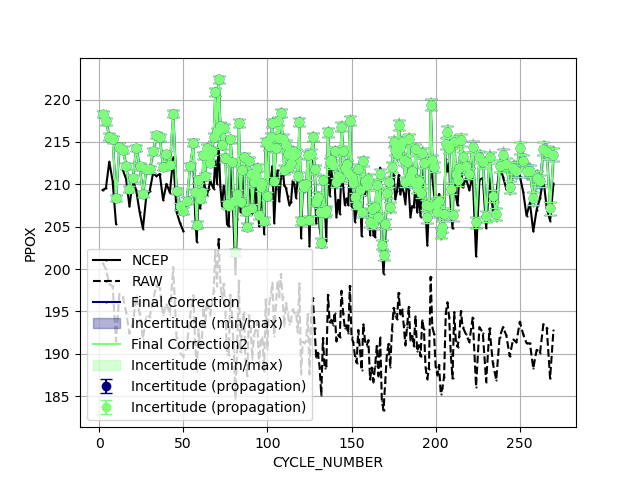

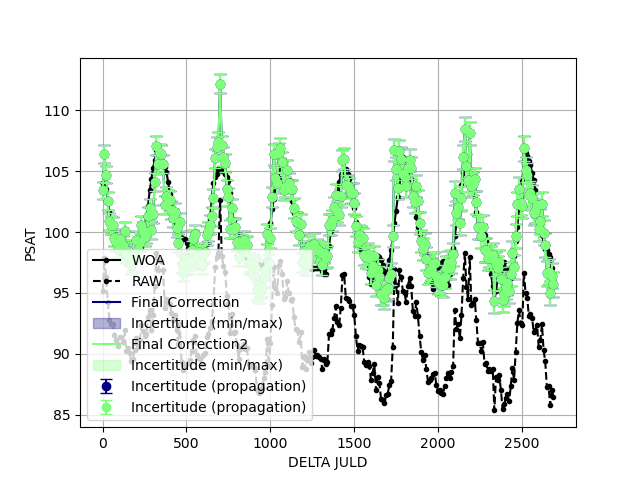

In [102]:
# Comparaison correction finale avec NCEP ET PSAT WOA
dict_corr = {'Final Correction' : np.stack((corr_final_without_pressure_correction, perr_final_pressure), axis=0),'Final Correction2' : np.stack((corr_final_without_pressure_correction, perr_final_pressure), axis=0)}
breakpoint_list=[[],[]]
_=plot_cmp_corr_NCEP_with_error2(dict_corr,breakpoint_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_NCEP_final_corr.png'))
breakpoint_list=[[],[]]
_=plot_cmp_corr_WOA_with_error2(dict_corr,breakpoint_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_PSATWOA_final_corr.png'))

In [169]:
from datetime import datetime
from m_read_write_netcdf import xarray_to_dict,write_netcdf

def corr_file2(fic_en_cours : str,fic_res : str,launch_date : np.datetime64,comment_corr :str,coef_corr : str,eq_corr : str,
              coef2 : float, coef3 : float, gain_final : np.float64 = 1,drift_final : np.float64=0,coef_pres:np.float64 = 0,percent_relative_error: np.float64=3) -> None : 
    """ Function to update the B_monoprofile with the DOXY_ADJUSTED

    Parameters
    ----------
    fic_en_cours : str
        Original file
    fic_res : str
        Result file
    launch_date : np.datetime64
        Launch Date
    comment_corr : str
        Information about DOXY Correction
    coef_corr : str
        Correction Coefficient
    eq_corr : str
        Correction Equation
    coef2, coef3 : float
         coefficient used in constructor pressure effect : (1 + (coef2 * Temp + coef3)*Pres/1000)       
    gain_final : np.float
        Slope to apply (default = 1)
    drift_final : np.float
        Drift to apply (default = 0)
    coef_pres : np.float
        Correction for pressure effect (default = 0)

    Returns
    -------
    None
    The file fic_res is created, containing the DOXY_ADJUSTED
    
    

    Returns
    -------
    None
    The result file is created
    """
    dsargo_oxy = xr.open_dataset(fic_en_cours,engine='argo')
    delta_T = diff_time_in_days(dsargo_oxy['JULD'],launch_date)
    nb_depth = len(dsargo_oxy['N_LEVELS'])
    nb_profil = len(dsargo_oxy['N_PROF'])
    delta_T = delta_T.to_numpy()
    delta_T = delta_T.reshape(nb_profil,1)
    delta_T = np.tile(delta_T,nb_depth)
    doxy_index = np.where(dsargo_oxy['PARAMETER'].str.strip() =='DOXY')

    # Pas de PSAL dans les fichier B. Il faut lire dans le fichier R ou D
    dir_path, filename = os.path.split(fic_en_cours)
    new_filename = 'D' + filename[2:]
    new_filepath = os.path.join(dir_path, new_filename)
    if os.path.exists(new_filepath)==False:
        print('merdum',~os.path.exists(new_filepath))
        new_filename = 'R' + filename[2:]
        new_filepath = os.path.join(dir_path, new_filename)
        
    print(new_filepath)
    ds = xr.open_dataset(new_filepath,engine='argo')
    if 'PSAL_ADJUSTED' in ds.data_vars:
        str_chaine = '_ADJUSTED'
    else:
        str_chaine = ''

    str_chaine = ''
        
    ana_dens = sw.pden(ds['PSAL'+str_chaine],ds['TEMP'+str_chaine],ds['PRES'+str_chaine],0) # Adjusted ou pas. Ou alors prendre adjusted si existe, sinon raw
    O2_umolL = umolkg_to_umolL(dsargo_oxy['DOXY'],dsargo_oxy['DOXY'].units,ana_dens[0])
    ppox_cycle = O2ctoO2p(O2_umolL,ds['TEMP'+str_chaine].isel(N_PROF=0),ds['PSAL'+str_chaine].isel(N_PROF=0),ds['PRES'+str_chaine].isel(N_PROF=0)) 
    dsargo_oxy.close()


    dsargo_oxy = xr.open_dataset(fic_en_cours,decode_cf = False)
    
#    for vname in dsargo_oxy:
#        if "_FillValue" in dsargo_oxy[vname].attrs and isinstance(dsargo_oxy[vname]._FillValue, bytes):
#            dsargo_oxy[vname].attrs["_FillValue"] = dsargo_oxy[vname].attrs["_FillValue"].decode("utf8")

    for i_prof in range(nb_profil):
        ppox_ARGO_corr = (gain_final * (1+drift_final/100 * delta_T[i_prof,:]/365))* ppox_cycle[i_prof,:] # A rajouter offset si on en a 1 differente de 0.
        if coef_pres != 0:
            dir_name = os.path.dirname(fic_en_cours)
            base_name = os.path.basename(fic_en_cours)
            raw_file = 'R' + base_name[2:]
            full_raw_file = os.path.join(dir_name, raw_file)
            if os.path.exists(full_raw_file)==False:
                raw_file = 'D' + base_name[2:]
                full_raw_file = os.path.join(dir_name, raw_file)
                
            ds_ctd = xr.open_dataset(full_raw_file,engine='argo')
            print(f"Lecture de la temperature du fichier {full_raw_file} pour correction de l'effet de pression\n")  

            # Interpolation de TEMP sur PRES de ds1 pour ce profil
            temp_interp = np.interp(dsargo_oxy['PRES'].isel(N_PROF=i_prof), ds_ctd['PRES'].isel(N_PROF=i_prof), ds_ctd['TEMP'].isel(N_PROF=i_prof))
            ds_ctd.close()
            
            ppox_ARGO_corr = ppox_ARGO_corr/(1 + (coef2*temp_interp + coef3) *dsargo_oxy['PRES'].isel(N_PROF=i_prof)/1000)  # We undo the pressure correction done in coriolis dac
            ppox_ARGO_corr=  (1 + (coef2*temp_interp + coef_pres) *dsargo_oxy['PRES'].isel(N_PROF=i_prof)/1000) * ppox_ARGO_corr # We apply the new pressure effect

        O2_ARGO_corr = O2ptoO2c(ppox_ARGO_corr,ds['TEMP'+str_chaine].isel(N_PROF=0),ds['PSAL'+str_chaine].isel(N_PROF=0),ds['PRES'+str_chaine].isel(N_PROF=0)) 
        O2_ARGO_corr = O2_ARGO_corr * (1000/ana_dens[i_prof,:]) # Conversion en mmol/Kg
        dsargo_oxy['DOXY_ADJUSTED'].loc[dict(N_PROF=i_prof)] =  O2_ARGO_corr 
        dsargo_oxy['DOXY_ADJUSTED_ERROR'].loc[dict(N_PROF=i_prof)] =  O2_ARGO_corr * percent_relative_error /100




    # FillValue where no DOXY DATA
    dsargo_oxy['DOXY_ADJUSTED'] = dsargo_oxy['DOXY_ADJUSTED'].where(dsargo_oxy['DOXY']!=dsargo_oxy['DOXY'].attrs['_FillValue'],dsargo_oxy['DOXY_ADJUSTED'].attrs['_FillValue'])
    #dsargo_oxy['DOXY_ADJUSTED'] = dsargo_oxy['DOXY_ADJUSTED'].where(((dsargo_oxy['DOXY_QC']==1) | (dsargo_oxy['DOXY_QC']==2) | (dsargo_oxy['DOXY_QC']==3)),dsargo_oxy['DOXY_ADJUSTED'].attrs['_FillValue'])
    dsargo_oxy['DOXY_ADJUSTED_QC'] = dsargo_oxy['DOXY_QC']
    mask = dsargo_oxy['DOXY_QC'].isin([b'1', b'2', b'3'])  # Flag 1/2/3 ==> flag 1 because they are corrected
    dsargo_oxy['DOXY_ADJUSTED_QC'] = dsargo_oxy['DOXY_ADJUSTED_QC'].where(~mask, np.array(b'1', dtype='S1'))  

    mask = dsargo_oxy['DOXY_ADJUSTED_QC'].isin([b'4', b'9'])  # Flag 4/9 ==> FillValue
    dsargo_oxy['DOXY_ADJUSTED'] = dsargo_oxy['DOXY_ADJUSTED'].where(~mask, dsargo_oxy['DOXY_ADJUSTED'].attrs['_FillValue'])  
    dsargo_oxy['DOXY_ADJUSTED_ERROR'] = dsargo_oxy['DOXY_ADJUSTED_ERROR'].where(dsargo_oxy['DOXY_ADJUSTED']!=dsargo_oxy['DOXY_ADJUSTED'].attrs['_FillValue'],dsargo_oxy['DOXY_ADJUSTED_ERROR'].attrs['_FillValue'])
    #dsargo_oxy['DOXY_ADJUSTED'] = dsargo_oxy['DOXY_ADJUSTED'].where(((dsargo_oxy['DOXY_QC']==b'1') | (dsargo_oxy['DOXY_QC']==b'2') | (dsargo_oxy['DOXY_QC']==b'3')),dsargo_oxy['DOXY_ADJUSTED'].attrs['_FillValue'])



    for n_prof, n_calib, n_param in zip(*doxy_index):
        dsargo_oxy['PARAMETER_DATA_MODE'].loc[dict(N_PROF=n_prof,N_PARAM=n_param)] = 'D'
        dsargo_oxy['DATA_MODE'].loc[dict(N_PROF=n_prof)] = 'D'

    # Creation of dataset with variables with N_CALIB dimension
    var_n_calib = [var for var in dsargo_oxy.data_vars if "N_CALIB" in dsargo_oxy[var].dims]
    ds2 = dsargo_oxy[var_n_calib]
    ds2 = xr.concat([ds2,ds2.isel(N_CALIB=-1)],dim='N_CALIB')
    nb_calib = len(ds2['N_CALIB'])
    #doxy_index = np.where(ds2['PARAMETER'].isel(N_CALIB=nb_calib-1).str.strip() =='DOXY') 
    #doxy_index = np.where(ds2['PARAMETER'].isel(N_CALIB=nb_calib-1).str.strip().values =='DOXY') 

    for n_prof, n_calib_bid, n_param in zip(*doxy_index):
        ds2['SCIENTIFIC_CALIB_COMMENT'].loc[dict(N_PROF=n_prof,N_PARAM=n_param,N_CALIB=n_calib)] = list(('{: <256}'.format(comment_corr))) 
        ds2['SCIENTIFIC_CALIB_DATE'].loc[dict(N_PROF=n_prof,N_PARAM=n_param,N_CALIB=n_calib)] = list(datetime.now().strftime("%Y%m%d%H%M%S"))
        ds2['SCIENTIFIC_CALIB_COEFFICIENT'].loc[dict(N_PROF=n_prof,N_PARAM=n_param,N_CALIB=n_calib)] = list(('{: <256}'.format(coef_corr)))
        ds2['SCIENTIFIC_CALIB_EQUATION'].loc[dict(N_PROF=n_prof,N_PARAM=n_param,N_CALIB=n_calib)] = list(('{: <256}'.format(eq_corr)))

    
    
    ds3 = dsargo_oxy.drop_dims('N_CALIB')
    ds3['DATE_UPDATE'][:] = list(datetime.now().strftime("%Y%m%d%H%M%S"))
    ds3 = ds3.merge(ds2)
    #ds3.to_netcdf(fic_res)

    # PROFILE_DOXY_QC
    good_flags = [b'1', b'2', b'5', b'8']
    bad_flags = [b'3', b'4']

    for i in range(ds3.sizes['N_PROF']):
        doxy_qc_en_cours = ds3['DOXY_ADJUSTED_QC'].isel(N_PROF=i)
        good_count = np.isin(doxy_qc_en_cours, good_flags).sum()
        bad_count = np.isin(doxy_qc_en_cours, bad_flags).sum()
        total = good_count + bad_count # flag 0 and 9 are ignored

        if total!=0:
            if good_count == total:  # Tous les DOXY_QC sont bons
                ds3['PROFILE_DOXY_QC'].loc[dict(N_PROF=i)] = b'A'
            elif good_count / total >= 0.75:  # 75% des DOXY_QC sont bons
                ds3['PROFILE_DOXY_QC'].loc[dict(N_PROF=i)] = b'B'
            elif good_count / total >= 0.5 :  # 75% des DOXY_QC sont bons
                ds3['PROFILE_DOXY_QC'].loc[dict(N_PROF=i)] = b'C'
            elif good_count / total >= 0.25 :  # 75% des DOXY_QC sont bons
                ds3['PROFILE_DOXY_QC'].loc[dict(N_PROF=i)] = b'D'
            elif good_count / total > 0 :  # 75% des DOXY_QC sont bons
                ds3['PROFILE_DOXY_QC'].loc[dict(N_PROF=i)] = b'D'
            else:
                ds3['PROFILE_DOXY_QC'].loc[dict(N_PROF=i)] = b' '
    
    dict_res = xarray_to_dict(ds3)
    write_netcdf(fic_res,dict_res,'N_HISTORY')

    dsargo_oxy.close()
    ds.close()
    return None


# B file correction

In [ ]:
# BR/BD files correction
val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
fic_argo.sort()

first_cycle_to_use = 1
last_cycle_to_use = 2

for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    ds = xr.open_dataset(fic_en_cours,engine='argo')
    cycle_en_cours = ds['CYCLE_NUMBER'].values[0]
    juld_en_cours = ds['JULD'].values[0]
    delta_T_en_cours = diff_time_in_days(juld_en_cours,launch_date)
    if (cycle_en_cours >= first_cycle_to_use) & (cycle_en_cours<=last_cycle_to_use):
        if nb_segment>1:
            index = next((x for x, val in enumerate(np.array(breaks_to_keep)) if val>= delta_T_en_cours),None)
            if index is None :
                if delta_T_en_cours < breaks_to_keep[0] :
                    index = 0
                elif delta_T_en_cours > breaks_to_keep[-1] :
                    index = len(breaks_to_keep) - 1
            if index > 0:
                index = index -1
            corr_final = corr_final_to_use[index,:]
        else :
            corr_final = corr_final_to_use
        
        coef_pres = corr_final[2]
        gain_final = corr_final[0]
        derive_final = corr_final[1]  
        coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, COEF_PRES ={coef_pres},OFFSET=0.000000'
        eq_corr = 'DOXY2 = DOXY / (1 + (Pcoef2*TEMP + coef3)*PRES/1000) * (1 + (Pcoef2*TEMP + coef_pres)*PRES/1000),DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365)+INCLINE_T*TEMP)*DOXY2'
        print(f'Correction de {fic_en_cours} avec {corr_final_to_use}')
        if os.path.exists(fic_res):
            os.remove(fic_res)
        #corr_file2(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,pcoef2,pcoef3,gain_final,derive_final,coef_pres,percent_relative_error)
        corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,pcoef2,pcoef3,gain_final,derive_final,coef_pres,percent_relative_error)

Correction de /Volumes/argo/gdac/dac/coriolis/6902807/profiles/BD6902807_001.nc avec [1.11024899 0.25269017 0.01297975]
Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/D6902807_001.nc pour correction de l'effet de pression

Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/D6902807_001.nc pour correction de l'effet de pression

Correction de /Volumes/argo/gdac/dac/coriolis/6902807/profiles/BD6902807_002.nc avec [1.11024899 0.25269017 0.01297975]
Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/D6902807_002.nc pour correction de l'effet de pression

Lecture de la temperature du fichier /Volumes/argo/gdac/dac/coriolis/6902807/profiles/D6902807_002.nc pour correction de l'effet de pression

